# Factor Modeling

In [1]:
# Imports
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import pprint as pp
import numpy as np
from typing import Optional
from utils import (
    FactorModel, ApiData, Logger, API_KEY,
    get_coin_price_series, get_equity_data, get_risk_free_rate,
    fetch_merged_crypto_data,
)
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import os
import matplotlib.ticker as mtickd
import yfinance as yf


import importlib
import utils
import pickle



/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/snowflake/connector/vendored/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
 pip install snowflake-connector-python[secure-local-storage]
/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/boto3/compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Initiating login request with your identity provider. Press CTRL+C to abort and try again...
Going to open: https://accounts.google.com/o/saml2/idp?idpid=C00rimqke&SAMLRequest=lZJbb%2BIwEIX%2FSuR9TuwEllKLgCgULStuKmn38uYmJlg4dvA4hO6vXyeA1H1opX2wZNnn%2BJvxmcHoXEjvxA0IrWIUBgR5XKU6EyqP0XMy8%2FvIA8tUxqRWPEZvHNBoOABWyJKOK7tXT%2FxYcbCee0gBbS5iVBlFNQMBVLGCA7Up3Y6XCxoFhDIAbqzDoaslA%2BFYe2tLinFd10HdCbTJcUQIweQeO1Uj%2BYLeIcrPGaXRVqda3ixn19MHiBCTboNwCkfYXI0PQl2%2B4DPK60UE9FuSbPzNepsgb3zrbqIVVAU3W25OIuXPT4tLAeAqmP9KVovku7%2F88RDedbqdAJSud5IdeKqLsrLu0cDt8I5nWOpcuK%2BaT2NUHkT2Z1GyfV701pND35TsvH7tnEi5PnZ30%2F6MLDovvZ%2FLVXc8%2B%2Fr4mCLv5RZs1AQ7B6j4XDVxWndEop5PQj%2FqJVFEI0K7JLgL738jb%2BriFIrZ1nmrmaWprpSFINc6l7ytT%2BMmiwiLrBy5JbJ4QogRxfHA0WVGaMs0w%2F%2FsfIDfm6%2FTtnIBzKcbLUX65s20KZj9OJ8wCNsTkfm7Vkp5wYQcZ5nhAC4nKXU9MZxZN9TWVBzh4YX671gP%2FwI%3D&RelayState=ver%3A1-hint%3A14675761562220210-ETMsDgAAAZv8ZRGOABRBRVMvQ0JDL1BLQ1M1UGFkZGluZwEAABAAEL9CKJrUiDNkIslEHp6x4fMAAACgjWOOj73sqEEiF9HLUAIhJbTcduJfIKrL3LbSjHU

/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/boto3/compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
 pip install snowflake-connector-python[secure-local-storage]


Factor Metrics Function

In [2]:
from pathlib import Path

def calculate_monthly_metrics(factor_model: FactorModel, returns_df: pd.DataFrame, rf_df: pd.DataFrame = None) -> pd.DataFrame:
    """
    Calculate monthly performance metrics for a factor model.
    
    Returns a DataFrame with:
    - Monthly Return (current month)
    - Yearly Return (current year)
    - Annualized Return
    - Volatility (annual)
    - Excess Return (annualized, over risk-free rate)
    - Sharpe Ratio
    - Sortino Ratio
    - Average Market Cap
    """
    now = datetime.now()
    current_year = now.year
    current_month = now.month
    
    # Convert returns dict to DataFrame if needed
    if isinstance(factor_model.factor_returns, dict):
        returns_data = pd.DataFrame(
            list(factor_model.factor_returns.items()),
            columns=['date', 'return']
        )
        returns_data['date'] = pd.to_datetime(returns_data['date'])
        returns_data = returns_data.set_index('date')
    else:
        returns_data = returns_df.copy()
    
    # Get the returns column name (could be 'return', 'momentum_v2', etc.)
    returns_col = returns_data.columns[0] if len(returns_data.columns) > 0 else 'return'
    
    # 1. Monthly Return (current month)
    current_month_returns = returns_data[
        (returns_data.index.year == current_year) & 
        (returns_data.index.month == current_month)
    ]
    if len(current_month_returns) > 0:
        monthly_return = (1 + current_month_returns[returns_col]).prod() - 1
    else:
        monthly_return = np.nan
    
    # 2. Yearly Return (current year)
    current_year_returns = returns_data[returns_data.index.year == current_year]
    if len(current_year_returns) > 0:
        yearly_return = (1 + current_year_returns[returns_col]).prod() - 1
    else:
        yearly_return = np.nan
    
    # 3. Annualized Return (from results_dict if available, otherwise calculate)
    if 'annualized_return' in factor_model.results_dict:
        annualized_return = factor_model.results_dict['annualized_return']
    else:
        # Calculate if not available
        if len(returns_data) > 0:
            days = (returns_data.index[-1] - returns_data.index[0]).days
            years = days / 365.25
            cumulative_return = (1 + returns_data[returns_col]).prod() - 1
            annualized_return = ((1 + cumulative_return) ** (1 / years)) - 1 if years > 0 else np.nan
        else:
            annualized_return = np.nan
    
    # 4. Volatility (annual)
    if len(returns_data) > 0:
        # Weekly volatility, annualized
        weekly_vol = returns_data[returns_col].std()
        annualized_vol = weekly_vol * np.sqrt(52)
    else:
        annualized_vol = np.nan
    
    # 5. Excess Return (annualized, over risk-free rate)
    returns_with_rf = None
    if rf_df is not None and len(returns_data) > 0:
        # Merge returns with risk-free rate on date
        returns_with_rf = returns_data.merge(
            rf_df[['rf_weekly']], 
            left_index=True, 
            right_index=True, 
            how='left'
        )
        returns_with_rf['rf_weekly'] = returns_with_rf['rf_weekly'].fillna(0)
        
        # Calculate excess returns (return - risk-free rate)
        returns_with_rf['excess_return'] = returns_with_rf[returns_col] - returns_with_rf['rf_weekly']
        
        # Calculate annualized excess return
        if len(returns_with_rf) > 0:
            days = (returns_with_rf.index[-1] - returns_with_rf.index[0]).days
            years = days / 365.25
            cumulative_excess_return = (1 + returns_with_rf['excess_return']).prod() - 1
            annualized_excess_return = ((1 + cumulative_excess_return) ** (1 / years)) - 1 if years > 0 else np.nan
        else:
            annualized_excess_return = np.nan
    else:
        annualized_excess_return = np.nan
    
    # 6. Sharpe Ratio
    if 'sharpe_ratio' in factor_model.results_dict:
        sharpe_ratio = factor_model.results_dict['sharpe_ratio']
    elif len(returns_data) > 0:
        # Sharpe = (mean return / std of returns) * sqrt(periods per year)
        # Using weekly returns, so multiply by sqrt(52)
        mean_return = returns_data[returns_col].mean()
        std_return = returns_data[returns_col].std()
        if std_return > 0:
            sharpe_ratio = (mean_return / std_return) * np.sqrt(52)
        else:
            sharpe_ratio = np.nan
    else:
        sharpe_ratio = np.nan
    
    # 7. Sortino Ratio
    if 'sortino_ratio' in factor_model.results_dict:
        sortino_ratio = factor_model.results_dict['sortino_ratio']
    elif len(returns_data) > 0:
        # Sortino = (mean return / std of downside returns) * sqrt(periods per year)
        # Only use negative returns for downside deviation
        downside_returns = returns_data[returns_data[returns_col] < 0][returns_col]
        if len(downside_returns) > 0:
            mean_return = returns_data[returns_col].mean()
            downside_std = downside_returns.std()
            if downside_std > 0:
                sortino_ratio = (mean_return / downside_std) * np.sqrt(52)
            else:
                sortino_ratio = np.nan
        else:
            sortino_ratio = np.nan
    else:
        sortino_ratio = np.nan
    
    # 8. Max Drawdown (Current Week)
    max_drawdown_current_week = np.nan
    if len(returns_data) > 0:
        # Calculate cumulative returns from the beginning
        cumulative = (1 + returns_data[returns_col]).cumprod()
        
        # Calculate running maximum (peak)
        running_max = cumulative.expanding().max()
        
        # Calculate drawdown: (current - peak) / peak
        drawdown = (cumulative - running_max) / running_max
        
        # Get returns for the current week (current month)
        current_week_returns = returns_data[
            (returns_data.index.year == current_year) & 
            (returns_data.index.month == current_month)
        ]
        
        if len(current_week_returns) > 0:
            # Get drawdown values for the current week
            current_week_drawdown = drawdown[current_week_returns.index]
            # Maximum drawdown is the most negative value (or 0 if all positive)
            max_drawdown_current_week = current_week_drawdown.min()
        else:
            # If no data for current week, use the most recent week's drawdown
            if len(drawdown) > 0:
                max_drawdown_current_week = drawdown.iloc[-1]
    
    # 9. HHI (Herfindahl-Hirschman Index) - Portfolio Concentration
    hhi_long = np.nan
    hhi_short = np.nan
    if len(factor_model.factor_assets) > 0:
        # Get the most recent period
        sorted_dates = sorted(factor_model.factor_assets.keys())
        latest_date = sorted_dates[-1]
        
        # Calculate HHI for long portfolio
        long_portfolio = factor_model.factor_assets[latest_date]['long_portfolio']
        if len(long_portfolio) > 0:
            long_weights = [asset_data['weighting'] for asset_data in long_portfolio.values()]
            hhi_long = sum(w ** 2 for w in long_weights)
        
        # Calculate HHI for short portfolio
        short_portfolio = factor_model.factor_assets[latest_date].get('short_portfolio', {})
        if len(short_portfolio) > 0:
            short_weights = [asset_data['weighting'] for asset_data in short_portfolio.values()]
            hhi_short = sum(w ** 2 for w in short_weights)
    
    # Use average HHI of long and short, or just long if short is NaN
    hhi = np.nan
    if not np.isnan(hhi_long) and not np.isnan(hhi_short):
        hhi = (hhi_long + hhi_short) / 2
    elif not np.isnan(hhi_long):
        hhi = hhi_long
    elif not np.isnan(hhi_short):
        hhi = hhi_short
    
    # 10. Contribution to Return (Current Week) & Top Contributor
    total_contribution = np.nan
    top_contributor = "N/A"
    if len(factor_model.factor_assets) > 0:
        # Get the most recent period
        sorted_dates = sorted(factor_model.factor_assets.keys())
        latest_date = sorted_dates[-1]
        
        long_portfolio = factor_model.factor_assets[latest_date]['long_portfolio']
        short_portfolio = factor_model.factor_assets[latest_date].get('short_portfolio', {})
        
        # Calculate contributions for long positions (weight × return)
        long_contributions = {}
        for asset, asset_data in long_portfolio.items():
            weighting = asset_data['weighting']
            price_pct_change = asset_data.get('price_pct_change', 0)
            contribution = weighting * price_pct_change
            long_contributions[asset] = contribution
        
        # Calculate contributions for short positions (-weight × return)
        # For shorts, positive return = negative contribution, negative return = positive contribution
        short_contributions = {}
        for asset, asset_data in short_portfolio.items():
            weighting = asset_data['weighting']
            price_pct_change = asset_data.get('price_pct_change', 0)
            contribution = -weighting * price_pct_change  # Negative because we're short
            short_contributions[asset] = contribution
        
        # Combine all contributions
        all_contributions = {**long_contributions, **short_contributions}
        
        if len(all_contributions) > 0:
            # Total contribution is sum of all individual contributions
            total_contribution = sum(all_contributions.values())
            
            # Find the asset with the highest contribution (by absolute value or actual value)
            # Using absolute value to find the most impactful contributor
            top_contributor = max(all_contributions.items(), key=lambda x: abs(x[1]))[0]
    
    # 11. Average ADV (Average Daily Volume) for the Week
    avg_adv_week = np.nan
    if len(factor_model.factor_assets) > 0:
        # Get the most recent period
        sorted_dates = sorted(factor_model.factor_assets.keys())
        latest_date = sorted_dates[-1]
        
        # Get assets from the portfolio
        latest_portfolio = (
            list(factor_model.factor_assets[latest_date]['long_portfolio'].keys()) +
            list(factor_model.factor_assets[latest_date].get('short_portfolio', {}).keys())
        )
        
        # Get volume data for the latest date
        # Check if df has 'date' as index or column
        if 'date' in factor_model.df.columns:
            latest_date_data = factor_model.df[factor_model.df['date'] == latest_date]
        else:
            latest_date_data = factor_model.df[factor_model.df.index == latest_date]
        
        # Get 24h_volume for portfolio assets (this is weekly summed volume)
        portfolio_volumes = latest_date_data[
            latest_date_data['asset'].isin(latest_portfolio)
        ]['24h_volume']
        
        if len(portfolio_volumes) > 0:
            # Since data is weekly and volume is summed, divide by 7 to get average daily volume
            # Then take the average across all assets in the portfolio
            daily_volumes = portfolio_volumes / 7
            avg_adv_week = daily_volumes.mean()
    
    # 12. Average Market Cap
    if len(factor_model.factor_assets) > 0:
        # Get the most recent period
        sorted_dates = sorted(factor_model.factor_assets.keys())
        latest_date = sorted_dates[-1]
        
        # Get market caps from the df for assets in the portfolio
        latest_portfolio = (
            list(factor_model.factor_assets[latest_date]['long_portfolio'].keys()) +
            list(factor_model.factor_assets[latest_date].get('short_portfolio', {}).keys())
        )
        
        # Get market cap data for the latest date
        # Check if df has 'date' as index or column
        if 'date' in factor_model.df.columns:
            latest_date_data = factor_model.df[factor_model.df['date'] == latest_date]
        else:
            latest_date_data = factor_model.df[factor_model.df.index == latest_date]
        
        portfolio_mcs = latest_date_data[
            latest_date_data['asset'].isin(latest_portfolio)
        ]['mc_t_minus_1']
        
        if len(portfolio_mcs) > 0:
            avg_market_cap = portfolio_mcs.mean()
        else:
            # Fallback: try to get from factor_assets if mc is stored there
            avg_market_cap = np.nan
    else:
        avg_market_cap = np.nan
    
    # Create results DataFrame with formatted values
    metrics_df = pd.DataFrame({
        'metric': [
            'Monthly Return (Current Month)',
            'Yearly Return (Current Year)',
            'Annualized Return',
            'Volatility (Annual)',
            'Excess Return (Annualized)',
            'Sharpe Ratio',
            'Sortino Ratio',
            'Max Drawdown (Current Week)',
            'Dominance (HHI)',
            'Contribution to Return (Current Week)',
            'Top Contributor (Week)',
            'Average ADV (Week)',
            'Average Market Cap'
        ],
        'value': [
            monthly_return,
            yearly_return,
            annualized_return,
            annualized_vol,
            annualized_excess_return,
            sharpe_ratio,
            sortino_ratio,
            max_drawdown_current_week,
            hhi,
            total_contribution,
            top_contributor,
            avg_adv_week,
            avg_market_cap
        ],
        'value_formatted': [
            f"{monthly_return:.2%}" if not np.isnan(monthly_return) else "N/A",
            f"{yearly_return:.2%}" if not np.isnan(yearly_return) else "N/A",
            f"{annualized_return:.2%}" if not np.isnan(annualized_return) else "N/A",
            f"{annualized_vol:.2%}" if not np.isnan(annualized_vol) else "N/A",
            f"{annualized_excess_return:.2%}" if not np.isnan(annualized_excess_return) else "N/A",
            f"{sharpe_ratio:.2f}" if not np.isnan(sharpe_ratio) else "N/A",
            f"{sortino_ratio:.2f}" if not np.isnan(sortino_ratio) else "N/A",
            f"{max_drawdown_current_week:.2%}" if not np.isnan(max_drawdown_current_week) else "N/A",
            f"{hhi:.4f}" if not np.isnan(hhi) else "N/A",
            f"{total_contribution:.2%}" if not np.isnan(total_contribution) else "N/A",
            top_contributor,
            f"{avg_adv_week:,.0f}" if not np.isnan(avg_adv_week) else "N/A",
            f"${avg_market_cap:,.0f}" if not np.isnan(avg_market_cap) else "N/A"
        ],
        'as_of_date': [now.strftime('%Y-%m-%d')] * 13,
        'factor_name': [factor_model.factor] * 13
    })
    
    return metrics_df

def save_monthly_metrics(metrics_df: pd.DataFrame, output_dir: str = 'factor_logs'):
    """Save monthly metrics to CSV for tracking over time"""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create filename with factor name and date
    factor_name = metrics_df['factor_name'].iloc[0]
    as_of_date = metrics_df['as_of_date'].iloc[0]
    filename = f"{factor_name}_monthly_metrics.csv"
    filepath = output_path / filename
    
    # Append to CSV (create if doesn't exist)
    file_exists = filepath.exists()
    metrics_df.to_csv(filepath, mode='a', header=not file_exists, index=False)
    print(f"Metrics saved to {filepath}")
    return filepath

# Calculate and display metrics
# monthly_metrics_df = calculate_monthly_metrics(momentum_v2, momentum_factor_returns_df, rf_df=rf_df)

# Optionally save to CSV
# save_monthly_metrics(monthly_metrics_df)


def monthly_returns(factor_model, *, year: Optional[int] = None, months: Optional[int] = 12):
    r = pd.Series(factor_model.factor_returns).sort_index()
    r.index = pd.to_datetime(r.index)

    if year is not None:
        r = r.loc[r.index.year == year]

    if months is not None:
        if r.empty:
            return pd.Series(dtype=float)
        end = r.index.max()
        start = end - pd.DateOffset(months=months)
        r = r.loc[r.index >= start]

    m = r.groupby(pd.Grouper(freq="M")).apply(lambda x: (1 + x).prod() - 1)
    m.index = m.index.to_period("M").astype(str)
    return m


## Utils

In [3]:
def cumulative_returns(factor_returns):
    """Helper to calculate the cumulative returns for a factor"""
    returns_df = pd.DataFrame(list(factor_returns.items()), columns=['date', 'value'])
    returns_df['cumulative_returns'] = (1 + returns_df['value']).cumprod() - 1
    returns_df = returns_df[:-1]
    return returns_df

def plot_cumulative_returns(
    returns_df, 
    factor_model,
    factor_assets=None, 
    long_only_returns=None, 
    short_only_returns=None
    ):
    """Helper to plot the cumulative returns and number of assets each period for a factor"""
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    if long_only_returns is not None and short_only_returns is not None:
        long_only_returns = long_only_returns.rename(columns={'cumulative_returns': 'long_only_returns'})
        short_only_returns = short_only_returns.rename(columns={'cumulative_returns': 'short_only_returns'})
        merged_df = returns_df.merge(long_only_returns, on='date', how='left').merge(short_only_returns, on='date', how='left')
    else:
        merged_df = returns_df
    # Plot cumulative returns on primary axis with different colors
    ax1.plot(merged_df['date'], merged_df['cumulative_returns'], 
             linewidth=1.5, color='tab:blue', label='Cumulative Returns')
    
    if long_only_returns is not None:
        ax1.plot(merged_df['date'], merged_df['long_only_returns'], 
                 linewidth=1.5, color='tab:green', label='Long Only Returns')
    
    if short_only_returns is not None:
        ax1.plot(merged_df['date'], merged_df['short_only_returns'], 
                 linewidth=1.5, color='tab:red', label='Short Only Returns')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Returns')
    
    ax1.grid(True, alpha=0.3)
    
    # Plot factor assets on secondary axis if provided
    if factor_assets is not None:
        if isinstance(factor_assets, dict):
            factor_assets = pd.Series(factor_assets)
        
        ax2 = ax1.twinx()
        color2 = 'tab:orange'
        ax2.bar(factor_assets.index, factor_assets.values, 
                alpha=0.3, color=color2, label='# Assets', width=5)
        ax2.set_ylabel('Number of Assets', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.ticklabel_format(style='plain', axis='y')
        ax2.legend(loc='upper right')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(f'{factor_model.factor.upper()} Factor Performance')
    # reformat y axis ticks to percentage
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))
    # add annotation for all elements within factor_model.results_dict
    annualized_return = factor_model.results_dict['annualized_return']
    start_date = factor_model.results_dict['start_date']
    end_date = factor_model.results_dict['end_date']
    sharpe_ratio = factor_model.results_dict['sharpe_ratio']
    sortino_ratio = factor_model.results_dict['sortino_ratio']

    metrics_text = f"""
    Annualized Return: {annualized_return:>4.1%}    
    Sharpe Ratio: {sharpe_ratio:>4.2f}
    Sortino Ratio: {sortino_ratio:>4.2f}
    Start Date: {start_date:>4}
    End Date: {end_date:>4}
    """
    
    # Add text box in upper left corner
    props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
    ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

    plt.show()

def calculate_annualized_return(factor, returns_df):
    """Helper to calculate the annualized return for a factor"""
    dates = [pd.to_datetime(x) for x in factor.factor_returns.keys()]
    days = (dates[-1] - dates[0]).days
    years = days / 365
    cumulative_returns = returns_df['cumulative_returns'].iloc[-1]
    annualized_return = ((cumulative_returns + 1) ** (1 / years)) - 1
    print(f"""
        Factor Model: {factor.factor}
        Breakpoint: {factor.breakpoint}
        Min Assets: {factor.min_assets}
        Weighting Method: {factor.weighting_method}
        Annualized Return: {annualized_return}
        Cumulative Returns: {cumulative_returns}
        Years: {years}
    """)
    return annualized_return, cumulative_returns, years

def convert_to_log_returns(returns_dict: dict, weekly_rf_df: Optional[pd.DataFrame] = None) -> dict:
    if weekly_rf_df is not None:
        returns_df = pd.DataFrame(list(returns_dict.items()), columns=['date', 'value'])
        returns_df = returns_df.merge(weekly_rf_df, on='date', how='left').fillna(0)
        # net out risk free rate
        returns_df['value'] = returns_df['value'] - returns_df['rf_weekly']
        returns_df = returns_df[['date', 'value']]
        returns_df.set_index('date', inplace=True)
        # convert to log returns
        returns_df['value'] = np.log(1 + (returns_df['value']))
        # convert back to dict 
        returns_df_dict = returns_df.to_dict()
        return returns_df_dict['value']
    else:
        # return log returns in dict
        return {date: np.log(1 + ret) for date, ret in returns_dict.items()}

## Pull API data

In [4]:
# Uncomment and rerun when need to Pull API Data Again

# api_data = ApiData(API_KEY)
# metrics = ["price", "mc", "24h_volume", "mc_fees_ratio", "fees", "revenue", "active_revenue", "passive_revenue", "dau"]
# start_date = "2015-01-01"
# end_date = datetime.now().strftime("%Y-%m-%d")
# df = api_data.get_metric_for_all_symbols(metrics=metrics, start_date=start_date, end_date=end_date)


In [5]:
# df.to_pickle('factor_data_cache.pkl')
# print(f"Saved {len(df)} rows to cache")

In [6]:
df = pd.read_pickle('factor_data_cache.pkl')
print(f"Loaded {len(df)} rows from cache")

Loaded 561637 rows from cache


In [7]:
# Filter df to dates between Oct 1st, 2025 and today
oct_1 = "2025-10-01"
today = datetime.now().strftime("%Y-%m-%d")
df_new = df[(df.index >= oct_1) & (df.index <= today)]
df_new.head()

,asset,24h_volume,active_revenue,dau,fees,mc,mc_fees_ratio,passive_revenue,price,revenue
date,,,,,,,,,,
2025-10-01,aave,4.277390e+08,14957.080000,23446.0,3.084903e+06,4.361361e+09,3.666568,407881.374777,285.979426,407881.374777
2025-10-01,abstract,NaN,NaN,48585.0,1.292839e+04,NaN,NaN,12928.391702,NaN,12928.391702
2025-10-01,aca,3.739981e+06,NaN,144.0,8.367949e-02,2.911103e+07,276245.847617,0.016736,0.024936,0.016736
2025-10-01,acx,4.864105e+06,NaN,3293.0,0.000000e+00,7.200093e+07,634.525956,NaN,0.117719,0.000000
2025-10-01,ada,1.697702e+09,6743.494646,26972.0,8.429368e+03,3.101374e+10,9538.398044,1685.873662,0.849177,8429.368308


/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/2765110441.py:15: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  filtered_df["price_mom_30d"] = filtered_df.groupby("asset")["price"].pct_change(periods=30)
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/2765110441.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  momentum_series = momentum_ready.groupby("date").apply(_mc_weighted_average)


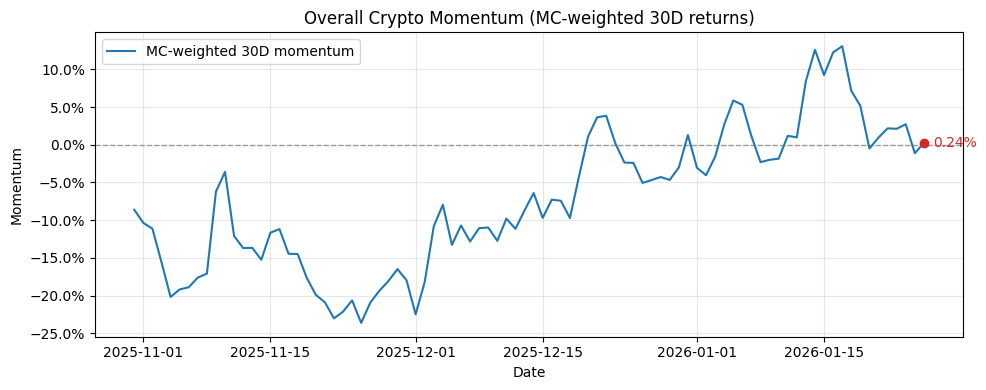

date
2026-01-22    0.021721
2026-01-23    0.021131
2026-01-24    0.027188
2026-01-25   -0.011261
2026-01-26    0.002371
Name: mc_weighted_30d_momentum, dtype: float64

In [8]:
raw_df = df_new
raw_df = raw_df.reset_index()
raw_df = raw_df.sort_values(["asset", "date"])

latest_snapshot = (
    raw_df.dropna(subset=["mc"])
    .sort_values("date")
    .groupby("asset")
    .tail(1)
    .sort_values("mc", ascending=False)
)
selected_assets = latest_snapshot.head(80)["asset"].tolist()
filtered_df = raw_df[raw_df["asset"].isin(selected_assets)].copy()

filtered_df["price_mom_30d"] = filtered_df.groupby("asset")["price"].pct_change(periods=30)
filtered_df["mc_lag"] = filtered_df.groupby("asset")["mc"].shift(1)

momentum_ready = filtered_df.dropna(subset=["price_mom_30d", "mc_lag"]).copy()


def _mc_weighted_average(group: pd.DataFrame) -> float:
    weights = group["mc_lag"].astype(float)
    numerator = (group["price_mom_30d"].astype(float) * weights).sum()
    denominator = weights.sum()
    if denominator == 0:
        return float("nan")
    return numerator / denominator

momentum_series = momentum_ready.groupby("date").apply(_mc_weighted_average)
momentum_series = momentum_series.dropna().sort_index()
momentum_series.name = "mc_weighted_30d_momentum"

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(momentum_series.index, momentum_series.values, label="MC-weighted 30D momentum", color="#1f77b4")
ax.axhline(0, color="#666666", linewidth=1, linestyle="--", alpha=0.6)

if not momentum_series.empty:
    last_date = momentum_series.index[-1]
    last_val = momentum_series.iloc[-1]
    ax.scatter([last_date], [last_val], color="#d62728", zorder=5)
    ax.text(
        last_date + pd.Timedelta(days=1),
        last_val,
        f"{last_val:.2%}",
        color="#d62728",
        va="center",
        fontsize=10,
    )

ax.set_title("Overall Crypto Momentum (MC-weighted 30D returns)")
ax.set_ylabel("Momentum")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter(mtickd.PercentFormatter(1))
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

momentum_series.tail()


### Data Connections

Snowflake removed. Using yfinance for risk-free rate (^IRX) and Coinbase for crypto prices.

In [9]:
# Snowflake connection removed — no longer needed

### Risk Free Rate

In [10]:
rf_df = get_risk_free_rate()

# Resample to weekly for consistency with factor model frequency
rf_df_weekly = rf_df.resample('W').last().dropna()
rf_df_weekly.head()


,rf_apy,rf_weekly
date,,
2025-12-28,0.024455,0.000470
2026-01-04,0.024152,0.000464
2026-01-11,0.023412,0.000450
2026-01-18,0.023070,0.000444
2026-01-25,0.023648,0.000455


## Construct Time Series Factors

### Size Factor
Tests whether small caps command a risk premium over large caps.

/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[



        Factor Model: smb
        Breakpoint: 0.5
        Min Assets: 40
        Weighting Method: equal
        Annualized Return: 0.44494063569940767
        Cumulative Returns: 5.773015659632962
        Years: 5.197260273972603
    


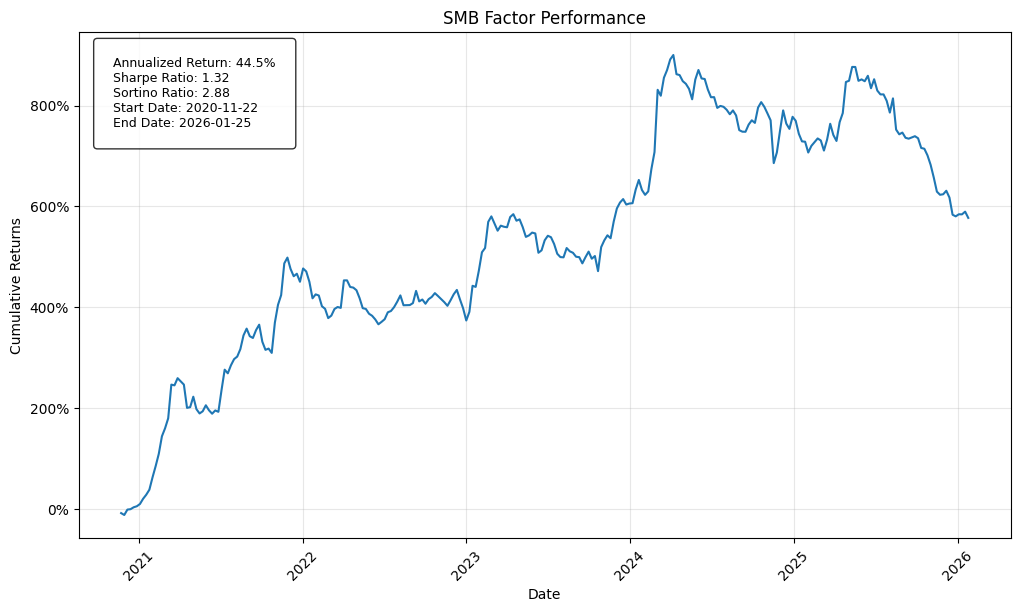

In [11]:
smb = FactorModel(df=df, factor='smb', breakpoint=0.5, min_assets=40, weighting_method='equal')
smb_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
}
smb.resample('W', smb_metric_agg_method_map)
smb.calculate_price_pct_change()
smb.get_t_minus_1_metrics(metrics=['mc', '24h_volume'])
smb.market_cap_threshold(threshold=100000000) # 100,000,000
smb.liquidity_threshold(threshold=35000000) # $5M / day
smb.minimum_lifetime(days=30)
smb.df['variance'] = smb.df.groupby('asset')['price_pct_change_p1'].transform('var')
smb.df['inverse_variance'] = 1 / smb.df['variance']

for date, group in smb.df.groupby('date'):
    smb_group = group.dropna(subset=['mc_t_minus_1', f'price_pct_change_p1'])
    big = smb_group.nlargest(int(len(smb_group) * smb.breakpoint), 'mc_t_minus_1')
    small = smb_group.nsmallest(int(len(smb_group) * smb.breakpoint), 'mc_t_minus_1')

    if len(small) < smb.min_assets / 2 and len(big) < smb.min_assets / 2:
        continue
    else:
        if smb.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif smb.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        elif smb.weighting_method == 'inverse_variance':
            weighted_avg = lambda df: (df['inverse_variance'] * df['price_pct_change_p1']).sum() / df['inverse_variance'].sum()
        else: 
            raise ValueError(f"Invalid weighting method: {smb.weighting_method}")
            
        long_asset_details = {}
        short_asset_details = {}
        # iterate through small and parse out asset and weighting
        for _,row in small.iterrows():
            asset = row['asset']
            if smb.weighting_method == 'equal':
                weighting = 1 / len(small)
            elif smb.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / small['mc_t_minus_1'].sum()
            elif smb.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / small['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {smb.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1']}

        for _, row in big.iterrows():
            asset = row['asset']
            if smb.weighting_method == 'equal':
                weighting = 1 / len(big)
            elif smb.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / big['mc_t_minus_1'].sum()
            elif smb.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / big['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {smb.weighting_method}")

            short_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1']}
        
        smb.factor_assets[date] = {
            'long_portfolio': long_asset_details,
            'short_portfolio': short_asset_details
        }

        smb.factor_returns[date] = weighted_avg(small) - weighted_avg(big)
        smb.long_portfolio_returns[date] = weighted_avg(small)
        smb.short_portfolio_returns[date] = weighted_avg(big)

# plot factor performance
smb_factor_asset_cnts = {}
for key in smb.factor_assets.keys():
    smb_factor_asset_cnts[key] = len(smb.factor_assets[key]['long_portfolio']) + len(smb.factor_assets[key]['short_portfolio'])

smb_returns_df = cumulative_returns(smb.factor_returns)
smb_long_only_returns_df = cumulative_returns(smb.long_portfolio_returns)
smb_short_only_returns_df = cumulative_returns(smb.short_portfolio_returns)

smb_raw_returns_df = pd.DataFrame({
    'date': list(smb.factor_returns.keys()),
    'smb': list(smb.factor_returns.values())
}).set_index('date')

# sharpe ratio
sharpe_ratio = (smb_raw_returns_df['smb'].mean() / smb_raw_returns_df['smb'].std()) * np.sqrt(52)

# sortino ratio
smb_downside_returns = smb_raw_returns_df[smb_raw_returns_df['smb'] < 0]
sortino_ratio = (smb_raw_returns_df['smb'].mean() / smb_downside_returns['smb'].std()) * np.sqrt(52)

volatility = smb_raw_returns_df['smb'].std()
annualized_vol = volatility * np.sqrt(52)

smb_annualized_return, smb_cumulative_returns, smb_years = calculate_annualized_return(smb, smb_returns_df)

smb.results_dict = {
    'cumulative_returns': smb_cumulative_returns,
    'annualized_return': smb_annualized_return,
    'years': smb_years,
    'long_only_returns': smb_long_only_returns_df['cumulative_returns'].iloc[-1],
    'short_only_returns': smb_short_only_returns_df['cumulative_returns'].iloc[-1],
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'start_date': list(smb.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(smb.factor_returns.keys())[-2].strftime('%Y-%m-%d'),
}

plot_cumulative_returns(smb_returns_df, smb)

# smb_logger = Logger(log_dir='factor_logs', factor_model=smb)
# smb_logger.log_results(smb.results_dict)

monthly_metrics_df_smb = calculate_monthly_metrics(smb, smb_returns_df, rf_df=rf_df)
        
    

In [12]:
# SMB Largest Drawdown:
# 2021-11-28 to 2022-06-19: -27%
monthly_metrics_df_smb

,metric,value,value_formatted,as_of_date,factor_name
0,Monthly Return (Current Month),-0.004512,-0.45%,2026-01-26,smb
1,Yearly Return (Current Year),0.002545,0.25%,2026-01-26,smb
2,Annualized Return,0.444941,44.49%,2026-01-26,smb
3,Volatility (Annual),0.315754,31.58%,2026-01-26,smb
4,Excess Return (Annualized),0.384055,38.41%,2026-01-26,smb
5,Sharpe Ratio,1.316831,1.32,2026-01-26,smb
6,Sortino Ratio,2.882415,2.88,2026-01-26,smb
7,Max Drawdown (Current Week),-0.32296,-32.30%,2026-01-26,smb
8,Dominance (HHI),0.014286,0.0143,2026-01-26,smb
9,Contribution to Return (Current Week),0.0,0.00%,2026-01-26,smb


### Market Beta

Top 10 assets by market cap. Weekly returns are market cap weighted.

/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[



        Factor Model: market
        Breakpoint: 0.5
        Min Assets: 10
        Weighting Method: market_cap
        Annualized Return: 0.3517762951197745
        Cumulative Returns: 12.249365260683826
        Years: 8.572602739726028
    


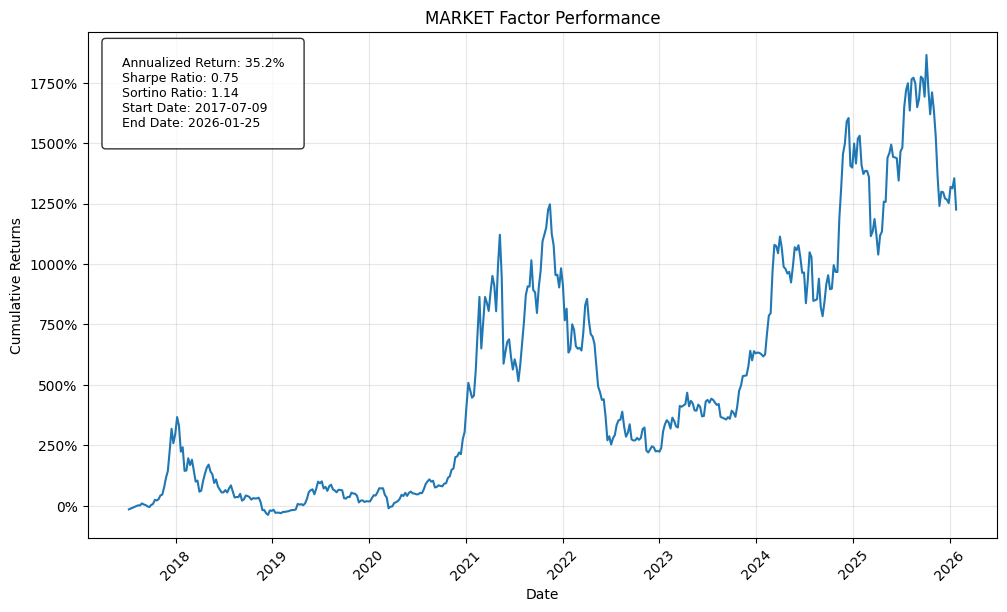

In [13]:
market = FactorModel(df=df, factor='market', breakpoint=0.5, min_assets=10, weighting_method='market_cap')
market_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
}
market.resample('W', market_metric_agg_method_map)
market.calculate_price_pct_change()
market.get_t_minus_1_metrics(metrics=['mc', '24h_volume'])
market.market_cap_threshold(threshold=100000000) # 100,000,000
market.liquidity_threshold(threshold=35000000) # $5M / day
market.minimum_lifetime(days=30)

for date, group in market.df.groupby('date'):
    market_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1'])
    big = market_group.nlargest(market.min_assets, 'mc_t_minus_1')

    if len(big) < market.min_assets:
        continue
    else:
        if market.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif market.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        else: 
            raise ValueError(f"Invalid weighting method: {market.weighting_method}")
            
        long_asset_details = {}
        
        for _, row in big.iterrows():
            asset = row['asset']
            if market.weighting_method == 'equal':
                weighting = 1 / len(big)
            elif market.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / big['mc_t_minus_1'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {market.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1']}
        
        market.factor_assets[date] = {
            'long_portfolio': long_asset_details
        }

        market.factor_returns[date] = weighted_avg(big)
        market.long_portfolio_returns[date] = weighted_avg(big)

market_returns_df = cumulative_returns(market.factor_returns)
market_returns_df = market_returns_df.merge(rf_df, on='date', how='left').fillna(0)
market_returns_df['value'] = market_returns_df['value'] - market_returns_df['rf_weekly']
market_returns_df = market_returns_df[['date', 'value', 'cumulative_returns']]

market_annualized_return, market_cumulative_returns, market_years = calculate_annualized_return(market, market_returns_df)

market_raw_returns_df = pd.DataFrame({
    'date': list(market.factor_returns.keys()),
    'market': list(market.factor_returns.values())
}).set_index('date')

market_downside_returns = market_raw_returns_df[market_raw_returns_df['market'] < 0]
market_sortino_ratio = (market_raw_returns_df['market'].mean() / market_downside_returns['market'].std()) * np.sqrt(52)
        
market_sharpe_ratio = (market_returns_df['value'].mean() / market_returns_df['value'].std()) * np.sqrt(52)

volatility = market_raw_returns_df['market'].std()
annualized_vol = volatility * np.sqrt(52)

market.results_dict = {
    'annualized_return': market_annualized_return,
    'sharpe_ratio': market_sharpe_ratio,
    'sortino_ratio': market_sortino_ratio,
    'start_date': list(market.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(market.factor_returns.keys())[-2].strftime('%Y-%m-%d')
}

plot_cumulative_returns(market_returns_df, market)
monthly_metrics_df_market = calculate_monthly_metrics(market, market_returns_df, rf_df=rf_df)


# market_logger = Logger(log_dir='factor_logs', factor_model=market)
# market_logger.log_results(market.results_dict)

In [14]:
monthly_metrics_df_market

,metric,value,value_formatted,as_of_date,factor_name
0,Monthly Return (Current Month),-0.019886,-1.99%,2026-01-26,market
1,Yearly Return (Current Year),0.002323,0.23%,2026-01-26,market
2,Annualized Return,0.351776,35.18%,2026-01-26,market
3,Volatility (Annual),0.688139,68.81%,2026-01-26,market
4,Excess Return (Annualized),0.319176,31.92%,2026-01-26,market
5,Sharpe Ratio,0.750808,0.75,2026-01-26,market
6,Sortino Ratio,1.139131,1.14,2026-01-26,market
7,Max Drawdown (Current Week),-0.325603,-32.56%,2026-01-26,market
8,Dominance (HHI),0.524789,0.5248,2026-01-26,market
9,Contribution to Return (Current Week),0.0,0.00%,2026-01-26,market


### Value

Uses mc_fees_ratio; Tests the assumption that high fee relative to market cap tokens command a risk premia over lower fee relative to market cap tokens. 

/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[



        Factor Model: value
        Breakpoint: 0.5
        Min Assets: 30
        Weighting Method: equal
        Annualized Return: -0.060091143287670845
        Cumulative Returns: -0.2391793110571664
        Years: 4.410958904109589
    


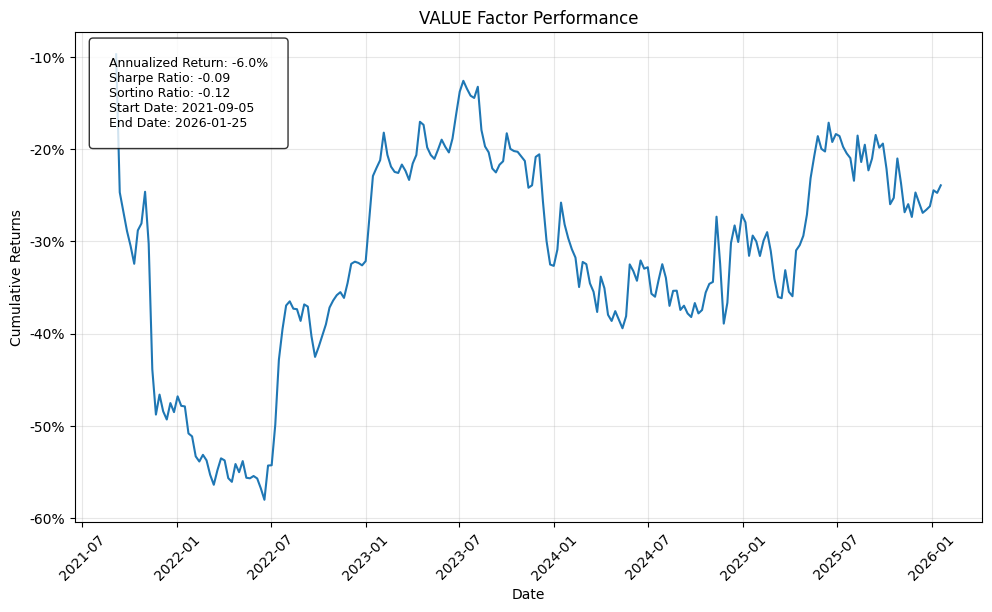

In [15]:
value = FactorModel(df=df, factor='value', breakpoint=0.5, min_assets=30, weighting_method='equal')
value_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'mc_fees_ratio': 'last'
}

value.resample('W', value_metric_agg_method_map)
value.calculate_price_pct_change()
value.get_t_minus_1_metrics(metrics=['mc', '24h_volume', 'mc_fees_ratio'])
value.market_cap_threshold(threshold=100000000) # 100,000,000
value.liquidity_threshold(threshold=35000000) # $5M / day
value.minimum_lifetime(days=30)
value.df['variance'] = value.df.groupby('asset')['price_pct_change_p1'].transform('var')
value.df['inverse_variance'] = 1 / value.df['variance']

for date, group in value.df.groupby('date'):
    value_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', 'mc_fees_ratio_t_minus_1'])
    low_value = value_group.nlargest(int(len(value_group) * value.breakpoint), 'mc_fees_ratio_t_minus_1')
    high_value = value_group.nsmallest(int(len(value_group) * value.breakpoint), 'mc_fees_ratio_t_minus_1')

    if len(low_value) < value.min_assets / 2 and len(high_value) < value.min_assets / 2:
        continue
    else:
        if value.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif value.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        elif value.weighting_method == 'inverse_variance':
            weighted_avg = lambda df: (df['inverse_variance'] * df['price_pct_change_p1']).sum() / df['inverse_variance'].sum()
        
        else: 
            raise ValueError(f"Invalid weighting method: {value.weighting_method}")
            
        long_asset_details = {}
        short_asset_details = {}
        # iterate through small and parse out asset and weighting
        for _, row in high_value.iterrows():
            asset = row['asset']
            if value.weighting_method == 'equal':
                weighting = 1 / len(high_value)
            elif value.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / high_value['mc_t_minus_1'].sum()
            elif value.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / high_value['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {value.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1'], 'mc_fees_ratio_zscore': row['mc_fees_ratio_t_minus_1']}

        for _, row in low_value.iterrows():
            asset = row['asset']
            if value.weighting_method == 'equal':
                weighting = 1 / len(low_value)
            elif value.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / low_value['mc_t_minus_1'].sum()
            elif value.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / low_value['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {value.weighting_method}")

            short_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1'], 'mc_fees_ratio_zscore': row['mc_fees_ratio_t_minus_1']}
        
        value.factor_assets[date] = {
            'long_portfolio': long_asset_details,
            'short_portfolio': short_asset_details
        }

        value.factor_returns[date] = weighted_avg(high_value) - weighted_avg(low_value)
        value.long_portfolio_returns[date] = weighted_avg(high_value)
        value.short_portfolio_returns[date] = weighted_avg(low_value)
        
value_factor_asset_cnts = {}
for key in value.factor_assets.keys():
    value_factor_asset_cnts[key] = len(value.factor_assets[key]['long_portfolio']) + len(value.factor_assets[key]['short_portfolio'])

value_returns_df = cumulative_returns(value.factor_returns)
value_returns_df = value_returns_df[:-1]
value_long_only_returns_df = cumulative_returns(value.long_portfolio_returns)
value_short_only_returns_df = cumulative_returns(value.short_portfolio_returns)
value_annualized_return, value_cumulative_returns, value_years = calculate_annualized_return(value, value_returns_df)

value_raw_returns_df = pd.DataFrame({
    'date': list(value.factor_returns.keys()),
    'value': list(value.factor_returns.values())
}).set_index('date')

# sortino ratio
value_downside_returns = value_raw_returns_df[value_raw_returns_df['value'] < 0]
sortino_ratio = (value_raw_returns_df['value'].mean() / value_downside_returns['value'].std()) * np.sqrt(52)

# sharpe ratio
sharpe_ratio = (value_raw_returns_df['value'].mean() / value_raw_returns_df['value'].std()) * np.sqrt(52)

volatility = value_raw_returns_df['value'].std()
annualized_vol = volatility * np.sqrt(52)

value.results_dict = {
    'cumulative_returns': value_cumulative_returns,
    'annualized_return': value_annualized_return,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'start_date': list(value.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(value.factor_returns.keys())[-2].strftime('%Y-%m-%d'),
    'years': value_years,
    'long_only_returns': value_long_only_returns_df['cumulative_returns'].iloc[-1],
    'short_only_returns': value_short_only_returns_df['cumulative_returns'].iloc[-1],
}

plot_cumulative_returns(value_returns_df, value)
monthly_metrics_df_value = calculate_monthly_metrics(value, value_returns_df, rf_df=rf_df)

# value_logger = Logger(log_dir='factor_logs', factor_model=value)
# value_logger.log_results(value.results_dict)

In [16]:
monthly_metrics_df_value

,metric,value,value_formatted,as_of_date,factor_name
0,Monthly Return (Current Month),0.018335,1.83%,2026-01-26,value
1,Yearly Return (Current Year),0.022381,2.24%,2026-01-26,value
2,Annualized Return,-0.060091,-6.01%,2026-01-26,value
3,Volatility (Annual),0.278911,27.89%,2026-01-26,value
4,Excess Return (Annualized),-0.10033,-10.03%,2026-01-26,value
5,Sharpe Ratio,-0.086746,-0.09,2026-01-26,value
6,Sortino Ratio,-0.119764,-0.12,2026-01-26,value
7,Max Drawdown (Current Week),-0.167549,-16.75%,2026-01-26,value
8,Dominance (HHI),0.02439,0.0244,2026-01-26,value
9,Contribution to Return (Current Week),0.0,0.00%,2026-01-26,value


### Momentum Factor
Ideas: 
- Signal Weighting vs. Equal Weighting
- Momentum Scoring vs. raw returns

Momentum v2 - sharpe weighted

/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/1262315578.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['price_pct_change'] = group['price'].pct_change()
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/1262315578.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['price_pct_change'] = group['price'].pct_change()
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/1262315578.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading 


        Factor Model: momentum
        Breakpoint: 0.25
        Min Assets: 30
        Weighting Method: equal
        Annualized Return: 0.7377130980601392
        Cumulative Returns: 14.233371889843315
        Years: 4.928767123287671
    


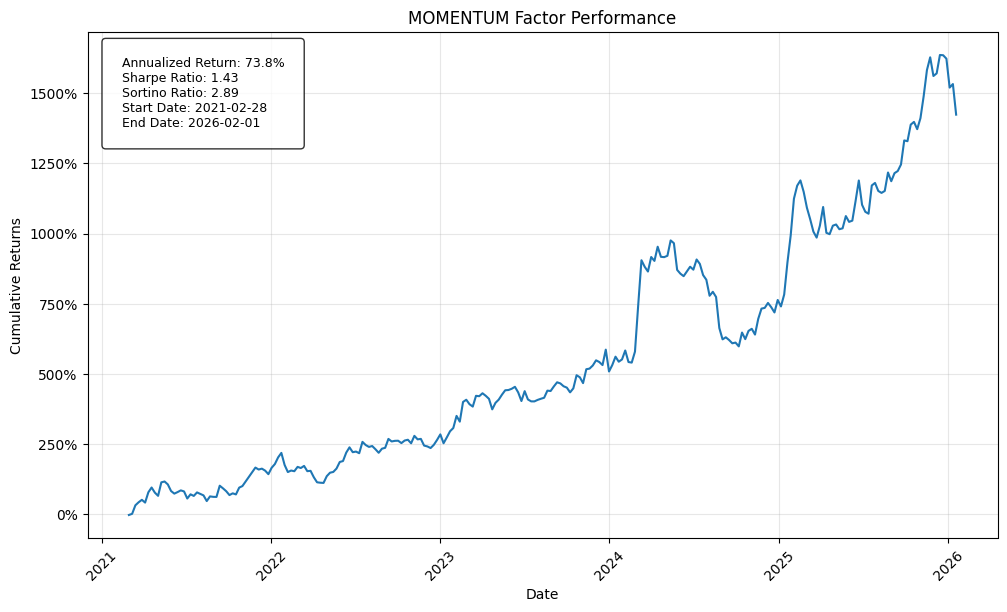

In [17]:
momentum_v2 = FactorModel(df=df, factor='momentum', breakpoint=0.25, min_assets=30, weighting_method='equal')

momentum_lookback_periods = 3
daily_lookback_period = momentum_lookback_periods * 7

# for each asset, find the trailing daily_lookback_period vol score; this is amended to derive based on daily returns, then gets resampled to weekly
def calculate_metrics(group):
    group['price_pct_change'] = group['price'].pct_change()
    # Rolling volatility adjustment
    # Mean return / std of returns over lookback period
    rolling_mean = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).mean()
    
    rolling_std = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).std()
    
    # Vol ratio (handle division by zero); Essentially a sharpe ratio
    group['vol_ratio'] = np.where(
        rolling_std > 0,
        np.abs(rolling_mean) / rolling_std,
        0
    )

    # Calculate raw momentum (compound return over lookback)
    group['raw_momentum'] = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).apply(lambda x: (1 + x).prod() - 1, raw=True)

    group['filtered_momentum'] = group['raw_momentum'] * group['vol_ratio']
    
    return group

momentum_v2.df = momentum_v2.df.groupby('asset', group_keys=False).apply(calculate_metrics)

momentum_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'vol_ratio': 'last',
    'filtered_momentum': 'last',
}

momentum_v2.resample('W', momentum_metric_agg_method_map)
momentum_v2.calculate_price_pct_change(periods=1)
momentum_v2.calculate_price_pct_change(periods=momentum_lookback_periods)

# apply t_minus_1 calculations here
momentum_v2.get_t_minus_1_metrics(metrics=['mc', '24h_volume', f'price_pct_change_p{momentum_lookback_periods}', 'vol_ratio', 'filtered_momentum']) # t minus 1 for mc and 24h_volume
# apply eligibility criteria after calculating metrics
momentum_v2.market_cap_threshold(threshold=100000000) # 100,000,000
momentum_v2.liquidity_threshold(threshold=35000000) # $5M / day
momentum_v2.minimum_lifetime(days=30)
momentum_v2.df['variance'] = momentum_v2.df.groupby('asset')['price_pct_change_p1'].transform('var')
momentum_v2.df['inverse_variance'] = 1 / momentum_v2.df['variance']


for date, group in momentum_v2.df.groupby('date'):
    momentum_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', f'price_pct_change_p{momentum_lookback_periods}_t_minus_1', 'filtered_momentum_t_minus_1'])
    high_momentum = momentum_group.nlargest(int(len(momentum_group) * momentum_v2.breakpoint), 'filtered_momentum_t_minus_1') # ranking by filtered momentum
    low_momentum = momentum_group.nsmallest(int(len(momentum_group) * momentum_v2.breakpoint), 'filtered_momentum_t_minus_1') # ranking by filtered momentum

    if len(low_momentum) < momentum_v2.min_assets / 2 and len(high_momentum) < momentum_v2.min_assets / 2:
        continue
    else:
        if momentum_v2.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif momentum_v2.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        elif momentum_v2.weighting_method == 'inverse_variance':
            weighted_avg = lambda df: (df['inverse_variance'] * df['price_pct_change_p1']).sum() / df['inverse_variance'].sum()
        else: 
            raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")
            
        long_asset_details = {}
        short_asset_details = {}
        # iterate through small and parse out asset and weighting
        for _, row in high_momentum.iterrows():
            asset = row['asset']
            if momentum_v2.weighting_method == 'equal':
                weighting = 1 / len(high_momentum)
            elif momentum_v2.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / high_momentum['mc_t_minus_1'].sum()
            elif momentum_v2.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / high_momentum['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}

        for _, row in low_momentum.iterrows():
            asset = row['asset']
            if momentum_v2.weighting_method == 'equal':
                weighting = 1 / len(low_momentum)
            elif momentum_v2.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / low_momentum['mc_t_minus_1'].sum()
            elif momentum_v2.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / low_momentum['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")

            short_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}
        
        momentum_v2.factor_assets[date] = {
            'long_portfolio': long_asset_details,
            'short_portfolio': short_asset_details
        }

        momentum_v2.factor_returns[date] = weighted_avg(high_momentum) - weighted_avg(low_momentum)
        momentum_v2.long_portfolio_returns[date] = weighted_avg(high_momentum)
        momentum_v2.short_portfolio_returns[date] = weighted_avg(low_momentum)
        
momentum_factor_asset_cnts = {}
for key in momentum_v2.factor_assets.keys():
    momentum_factor_asset_cnts[key] = len(momentum_v2.factor_assets[key]['long_portfolio']) + len(momentum_v2.factor_assets[key]['short_portfolio'])


momentum_raw_returns_df = pd.DataFrame({
    'date': list(momentum_v2.factor_returns.keys()),
    'momentum_v2': list(momentum_v2.factor_returns.values())
}).set_index('date')
momentum_returns_df = cumulative_returns(momentum_v2.factor_returns)
momentum_returns_df = momentum_returns_df[:-1]
momentum_long_only_returns_df = cumulative_returns(momentum_v2.long_portfolio_returns)
momentum_long_only_returns_df = momentum_long_only_returns_df[:-1]
momentum_short_only_returns_df = cumulative_returns(momentum_v2.short_portfolio_returns)
momentum_short_only_returns_df = momentum_short_only_returns_df[:-1]

sharpe_ratio = (momentum_returns_df['value'].mean() / momentum_returns_df['value'].std()) * np.sqrt(52)

momentum_v2_downside_returns = momentum_raw_returns_df[momentum_raw_returns_df['momentum_v2'] < 0]
sortino_ratio = (momentum_raw_returns_df['momentum_v2'].mean() / momentum_v2_downside_returns['momentum_v2'].std()) * np.sqrt(52)

volatility = momentum_raw_returns_df['momentum_v2'].std()
annualized_vol = volatility * np.sqrt(52)

momentum_annualized_return, momentum_cumulative_returns, momentum_years = calculate_annualized_return(momentum_v2, momentum_returns_df)

momentum_v2.results_dict = {
    'cumulative_returns': momentum_cumulative_returns,
    'annualized_return': momentum_annualized_return,
    'years': momentum_years,
    'long_only_returns': momentum_long_only_returns_df['cumulative_returns'].iloc[-1],
    'short_only_returns': momentum_short_only_returns_df['cumulative_returns'].iloc[-1],
    'trailing_momentum_lookback_periods': momentum_lookback_periods,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'start_date': list(momentum_v2.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(momentum_v2.factor_returns.keys())[-1].strftime('%Y-%m-%d'),
}

plot_cumulative_returns(momentum_returns_df, momentum_v2)
monthly_metrics_df_momentum_v2 = calculate_monthly_metrics(momentum_v2, momentum_returns_df, rf_df=rf_df)

# momentum_logger = Logger(log_dir='factor_logs', factor_model=momentum_v2)
# momentum_logger.log_results(momentum_v2.results_dict)

In [18]:
monthly_metrics_df_momentum_v2

,metric,value,value_formatted,as_of_date,factor_name
0,Monthly Return (Current Month),-0.14416,-14.42%,2026-01-26,momentum
1,Yearly Return (Current Year),-0.157481,-15.75%,2026-01-26,momentum
2,Annualized Return,0.737713,73.77%,2026-01-26,momentum
3,Volatility (Annual),0.456544,45.65%,2026-01-26,momentum
4,Excess Return (Annualized),0.648138,64.81%,2026-01-26,momentum
5,Sharpe Ratio,1.431309,1.43,2026-01-26,momentum
6,Sortino Ratio,2.889557,2.89,2026-01-26,momentum
7,Max Drawdown (Current Week),-0.150632,-15.06%,2026-01-26,momentum
8,Dominance (HHI),0.028571,0.0286,2026-01-26,momentum
9,Contribution to Return (Current Week),-0.015564,-1.56%,2026-01-26,momentum


### Growth
Ideas:
- composite metrics encompassing multiple fundamental metrics (dau, fees, etc.)
- I don't like relying on TVL & tbh I don't like DAU either but should probably test
- Fees, DAU, Revenue, Active Revenue, Passive Revenue, Earnings 
- the thing about revenue is it doesn't signify actual growth in usage / users / adoption etc. It is a value accrual metric, can be infrequent buybacks, etc. Can also have scenarios where revenue is 0 but fees are substantial
- don't like TVL since it is not applicable to all protocols and it is price-sensitive

/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/30773154.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['dau_pct_change'] = group['dau'].pct_change(periods=growth_lookback)
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/30773154.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['dau_pct_change'] = group['dau'].pct_change(periods=growth_lookback)
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_75747/30773154.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future versi


        Factor Model: growth
        Breakpoint: 0.5
        Min Assets: 30
        Weighting Method: equal
        Annualized Return: 0.40984076269856273
        Cumulative Returns: 3.0945887288437577
        Years: 4.104109589041096
    
Annualized volatility: 0.22579650477236596


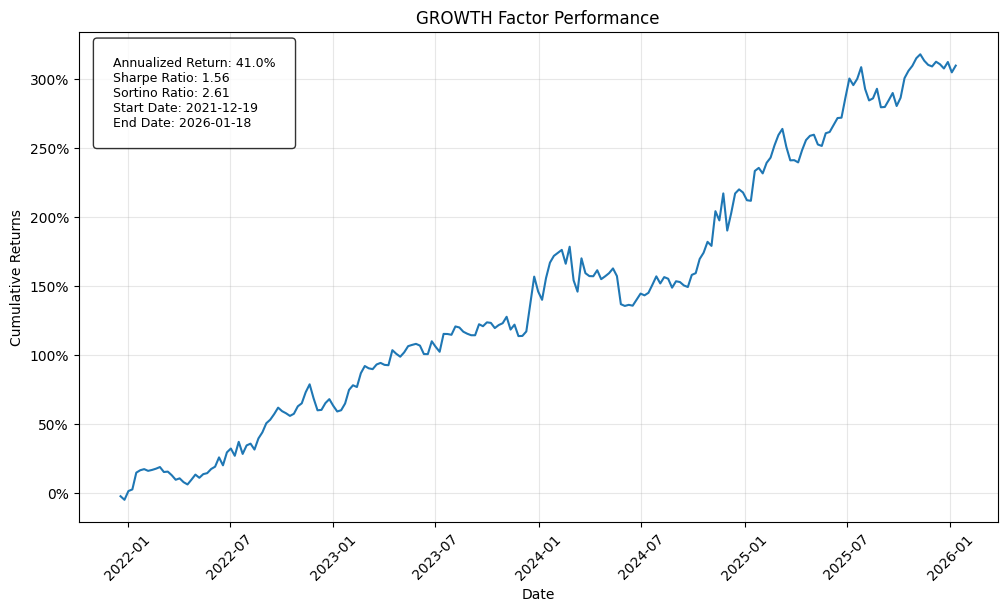

In [19]:
growth = FactorModel(df=df, factor='growth', breakpoint=0.5, min_assets=30, weighting_method='equal')
growth_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'fees': 'sum',
    'dau': 'mean',
    'revenue': 'sum',
    'active_revenue': 'sum',
    'passive_revenue': 'sum'
}

growth.resample('W', growth_metric_agg_method_map)

growth_lookback = 2 # in weeks

# for each asset, find the trailing growth_lookback week fee_pct_change
def calculate_growth_metrics(group):
    group['fees_pct_change'] = group['fees'].pct_change(periods=growth_lookback)
    group['dau_pct_change'] = group['dau'].pct_change(periods=growth_lookback)
    group['revenue_pct_change'] = group['revenue'].pct_change(periods=growth_lookback)
    group['active_revenue_pct_change'] = group['active_revenue'].pct_change(periods=growth_lookback)
    group['passive_revenue_pct_change'] = group['passive_revenue'].pct_change(periods=growth_lookback)
    return group

growth.df = growth.df.groupby('asset').apply(calculate_growth_metrics).reset_index(drop=True)
growth.calculate_price_pct_change()
growth.get_t_minus_1_metrics(metrics=['mc', '24h_volume', 'fees_pct_change', 'dau_pct_change', 'revenue_pct_change', 'active_revenue_pct_change', 'passive_revenue_pct_change'])
growth.market_cap_threshold(threshold=100000000) # 100,000,000
growth.liquidity_threshold(threshold=35000000) # $5M / day
growth.minimum_lifetime(days=30)
growth.df = growth.df[growth.df['dau'] > 100]
growth.df = growth.df[growth.df['fees'] > 500]
# calculate variance per asset over the assets entire timeframe
growth.df['variance'] = growth.df.groupby('asset')['price_pct_change_p1'].transform('var')
growth.df['inverse_variance'] = 1 / growth.df['variance']

for date, group in growth.df.groupby('date'):
    # get rid of inf or NaN
    group = group.replace([np.inf, -np.inf], np.nan)
    growth_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', 'dau_pct_change_t_minus_1', 'fees_pct_change_t_minus_1'])
    # winsorize dau_pct_change_t_minus_1 and fees_pct_change_t_minus_1
    growth_group['dau_pct_change_t_minus_1'] = winsorize(growth_group['dau_pct_change_t_minus_1'], limits=[0.05, 0.05])
    growth_group['fees_pct_change_t_minus_1'] = winsorize(growth_group['fees_pct_change_t_minus_1'], limits=[0.05, 0.05])

    # create z-score average composite score for each asset 
    growth_group['dau_pct_change_t_minus_1_zscore'] = (
        (growth_group['dau_pct_change_t_minus_1'] - growth_group['dau_pct_change_t_minus_1'].mean()) / 
        growth_group['dau_pct_change_t_minus_1'].std()
    )

    growth_group['fees_pct_change_t_minus_1_zscore'] = (
        (growth_group['fees_pct_change_t_minus_1'] - growth_group['fees_pct_change_t_minus_1'].mean()) / 
        growth_group['fees_pct_change_t_minus_1'].std()
    )
    growth_group['composite_score'] = (growth_group['dau_pct_change_t_minus_1_zscore'] + growth_group['fees_pct_change_t_minus_1_zscore']) / 2
    
    high_growth = growth_group.nlargest(int(len(growth_group) * growth.breakpoint), 'composite_score')
    low_growth = growth_group.nsmallest(int(len(growth_group) * growth.breakpoint), 'composite_score')

    if len(low_growth) < growth.min_assets / 2 and len(high_growth) < growth.min_assets / 2:
        continue
    else:
        if growth.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif growth.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        elif growth.weighting_method == 'inverse_variance':
            weighted_avg = lambda df: (df['inverse_variance'] * df['price_pct_change_p1']).sum() / df['inverse_variance'].sum()
        else:
            raise ValueError(f"Invalid weighting method: {growth.weighting_method}")
            
        long_asset_details = {}
        short_asset_details = {}
        # iterate through small and parse out asset and weighting
        for _, row in high_growth.iterrows():
            asset = row['asset']
            if growth.weighting_method == 'equal':
                weighting = 1 / len(high_growth)
            elif growth.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / high_growth['mc_t_minus_1'].sum()
            elif growth.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / high_growth['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {growth.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1'], 'dau_pct_change_t_minus_1_zscore': row['dau_pct_change_t_minus_1_zscore'], 'fees_pct_change_t_minus_1_zscore': row['fees_pct_change_t_minus_1_zscore'], 'composite_score': row['composite_score']}

        for _, row in low_growth.iterrows():
            asset = row['asset']
            if growth.weighting_method == 'equal':
                weighting = 1 / len(low_growth)
            elif growth.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / low_growth['mc_t_minus_1'].sum()
            elif growth.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / low_growth['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {growth.weighting_method}")

            short_asset_details[asset] = {'weighting': weighting, 'price_pct_change_p1': row['price_pct_change_p1'], 'dau_pct_change_t_minus_1_zscore': row['dau_pct_change_t_minus_1_zscore'], 'fees_pct_change_t_minus_1_zscore': row['fees_pct_change_t_minus_1_zscore'], 'composite_score': row['composite_score']}
        
        growth.factor_assets[date] = {
            'long_portfolio': long_asset_details,
            'short_portfolio': short_asset_details
        }

        growth.factor_returns[date] = weighted_avg(high_growth) - weighted_avg(low_growth)
        growth.long_portfolio_returns[date] = weighted_avg(high_growth)
        growth.short_portfolio_returns[date] = weighted_avg(low_growth)
        
growth_factor_asset_cnts = {}
for key in growth.factor_assets.keys():
    growth_factor_asset_cnts[key] = len(growth.factor_assets[key]['long_portfolio']) + len(growth.factor_assets[key]['short_portfolio'])

growth_returns_df = cumulative_returns(growth.factor_returns)
growth_returns_df = growth_returns_df[:-1]
growth_long_only_returns_df = cumulative_returns(growth.long_portfolio_returns)
growth_short_only_returns_df = cumulative_returns(growth.short_portfolio_returns)
growth_annualized_return, growth_cumulative_returns, growth_years = calculate_annualized_return(growth, growth_returns_df)

growth_raw_returns_df = pd.DataFrame({
    'date': list(growth.factor_returns.keys()),
    'growth': list(growth.factor_returns.values())
}).set_index('date')

# sortino ratio
growth_downside_returns = growth_raw_returns_df[growth_raw_returns_df['growth'] < 0]
sortino_ratio = (growth_raw_returns_df['growth'].mean() / growth_downside_returns['growth'].std()) * np.sqrt(52)

# sharpe ratio
sharpe_ratio = (growth_raw_returns_df['growth'].mean() / growth_raw_returns_df['growth'].std()) * np.sqrt(52)

# volati
volatility = growth_raw_returns_df['growth'].std()
annualized_vol = volatility * np.sqrt(52)
print(f"Annualized volatility: {annualized_vol}")

growth.results_dict = {
    'cumulative_returns': growth_cumulative_returns,
    'annualized_return': growth_annualized_return,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'start_date': list(growth.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(growth.factor_returns.keys())[-2].strftime('%Y-%m-%d'),
    'years': growth_years,
    'long_only_returns': growth_long_only_returns_df['cumulative_returns'].iloc[-1],
    'short_only_returns': growth_short_only_returns_df['cumulative_returns'].iloc[-1],
}

plot_cumulative_returns(growth_returns_df, growth)
monthly_metrics_df_growth = calculate_monthly_metrics(growth, growth_returns_df, rf_df=rf_df)

# growth_logger = Logger(log_dir='factor_logs', factor_model=growth)
# growth_logger.log_results(growth.results_dict)

In [20]:
monthly_metrics_df_growth

,metric,value,value_formatted,as_of_date,factor_name
0,Monthly Return (Current Month),-0.067254,-6.73%,2026-01-26,growth
1,Yearly Return (Current Year),-0.067254,-6.73%,2026-01-26,growth
2,Annualized Return,0.409841,40.98%,2026-01-26,growth
3,Volatility (Annual),0.225797,22.58%,2026-01-26,growth
4,Excess Return (Annualized),0.332455,33.25%,2026-01-26,growth
5,Sharpe Ratio,1.557837,1.56,2026-01-26,growth
6,Sortino Ratio,2.609719,2.61,2026-01-26,growth
7,Max Drawdown (Current Week),-0.079724,-7.97%,2026-01-26,growth
8,Dominance (HHI),0.030303,0.0303,2026-01-26,growth
9,Contribution to Return (Current Week),0.0,0.00%,2026-01-26,growth


## Testing

Process Includes:
1) Running regressions on 4 created sample portfolio's: Large Cap High Value, Large Cap Low Value, Small Cap High Value, Small Cap Low Value
    - Goal is to test whether our factor models successfully explain the returns of these sample portfolio's
2) Per asset regressions on all assets that satisfy the eligibility criteria. Note: The estimation windows per asset vary.
    

In [21]:
# Construct test portfolios; Subject to the same eligibility criteria as the factor models, minimum of 15 assets per period
test_portfolios = FactorModel(df=df, factor='test', min_assets=15)
test_portfolios.resample('W', {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'mc_fees_ratio': 'last'
    })
test_portfolios.calculate_price_pct_change()
test_portfolios.calculate_price_pct_change(periods=3)
test_portfolios.get_t_minus_1_metrics(metrics=['mc', '24h_volume', 'mc_fees_ratio', 'price_pct_change_p3'])
test_portfolios.market_cap_threshold(threshold=100000000) # 100,000,000
test_portfolios.liquidity_threshold(threshold=35000000) # $5M / day
test_portfolios.minimum_lifetime(days=30)

# Create sample portfolios
large_cap_high_value_returns = {}
large_cap_low_value_returns = {}
small_cap_high_value_returns = {}
small_cap_low_value_returns = {}
# momentum sorts 
large_cap_high_momentum_returns = {}
large_cap_low_momentum_returns = {}
small_cap_high_momentum_returns = {}
small_cap_low_momentum_returns = {}

# log assets in each portfolio for each period
large_cap_high_value_assets = {}
large_cap_low_value_assets = {}
small_cap_high_value_assets = {}
small_cap_low_value_assets = {}



for date, group in test_portfolios.df.groupby('date'):
    cleaned_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', 'mc_fees_ratio_t_minus_1'])
    large_cap_group = cleaned_group.nlargest(int(len(cleaned_group) * .5), 'mc_t_minus_1')
    small_cap_group = cleaned_group.nsmallest(int(len(cleaned_group) * .5), 'mc_t_minus_1')

    if len(large_cap_group) < test_portfolios.min_assets or len(small_cap_group) < test_portfolios.min_assets:
        continue
    
    else:
        # now split each into value terciles
        large_cap_high_value = large_cap_group.nsmallest(int(len(large_cap_group) * .3), 'mc_fees_ratio_t_minus_1')
        large_cap_high_value = large_cap_high_value.dropna()
        large_cap_high_value_assets[date] = large_cap_high_value
        large_cap_low_value = large_cap_group.nlargest(int(len(large_cap_group) * .3), 'mc_fees_ratio_t_minus_1')
        large_cap_low_value = large_cap_low_value.dropna()
        large_cap_low_value_assets[date] = large_cap_low_value

        large_cap_high_momentum = large_cap_group.nlargest(int(len(large_cap_group) * .3), 'price_pct_change_p3_t_minus_1')
        large_cap_high_momentum = large_cap_high_momentum.dropna()
        large_cap_low_momentum = large_cap_group.nsmallest(int(len(large_cap_group) * .3), 'price_pct_change_p3_t_minus_1')
        large_cap_low_momentum = large_cap_low_momentum.dropna()
        


        small_cap_high_value = small_cap_group.nsmallest(int(len(small_cap_group) * .3), 'mc_fees_ratio_t_minus_1')
        small_cap_high_value = small_cap_high_value.dropna()
        small_cap_high_value_assets[date] = small_cap_high_value
        small_cap_low_value = small_cap_group.nlargest(int(len(small_cap_group) * .3), 'mc_fees_ratio_t_minus_1')
        small_cap_low_value = small_cap_low_value.dropna()
        small_cap_low_value_assets[date] = small_cap_low_value

        small_cap_high_momentum = small_cap_group.nlargest(int(len(small_cap_group) * .3), 'price_pct_change_p3_t_minus_1')
        small_cap_high_momentum = small_cap_high_momentum.dropna()
        small_cap_low_momentum = small_cap_group.nsmallest(int(len(small_cap_group) * .3), 'price_pct_change_p3_t_minus_1')
        small_cap_low_momentum = small_cap_low_momentum.dropna()

        # now calculate the returns for each
        lchv_returns = large_cap_high_value['price_pct_change_p1'].mean()
        large_cap_high_value_returns[date] = lchv_returns
        lclv_returns = large_cap_low_value['price_pct_change_p1'].mean()
        large_cap_low_value_returns[date] = lclv_returns
        lchm_returns = large_cap_high_momentum['price_pct_change_p1'].mean()
        large_cap_high_momentum_returns[date] = lchm_returns
        lclm_returns = large_cap_low_momentum['price_pct_change_p1'].mean()
        large_cap_low_momentum_returns[date] = lclm_returns
        schv_returns = small_cap_high_value['price_pct_change_p1'].mean()
        small_cap_high_value_returns[date] = schv_returns
        sclv_returns = small_cap_low_value['price_pct_change_p1'].mean()
        small_cap_low_value_returns[date] = sclv_returns
        schm_returns = small_cap_high_momentum['price_pct_change_p1'].mean()
        small_cap_high_momentum_returns[date] = schm_returns
        sclm_returns = small_cap_low_momentum['price_pct_change_p1'].mean()
        small_cap_low_momentum_returns[date] = sclm_returns


/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[
/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[


In [22]:
# prep returns for regression
smb_returns = smb.factor_returns
value_returns = value.factor_returns 
market_returns = market.factor_returns
momentum_v2_returns = momentum_v2.factor_returns
growth_returns = growth.factor_returns
# convert to log returns 
smb_returns_log = convert_to_log_returns(smb_returns, rf_df)
value_returns_log = convert_to_log_returns(value_returns, rf_df)
market_returns_log = convert_to_log_returns(market_returns) # don't pass rf_df to market as this is already excess of rf rate
momentum_v2_returns_log = convert_to_log_returns(momentum_v2_returns, rf_df)
growth_returns_log = convert_to_log_returns(growth_returns, rf_df)
large_cap_high_value_returns_log = convert_to_log_returns(large_cap_high_value_returns, rf_df) 
large_cap_low_value_returns_log = convert_to_log_returns(large_cap_low_value_returns, rf_df)
large_cap_high_momentum_returns_log = convert_to_log_returns(large_cap_high_momentum_returns, rf_df)
large_cap_low_momentum_returns_log = convert_to_log_returns(large_cap_low_momentum_returns, rf_df)
small_cap_high_value_returns_log = convert_to_log_returns(small_cap_high_value_returns, rf_df)
small_cap_low_value_returns_log = convert_to_log_returns(small_cap_low_value_returns, rf_df)
small_cap_high_momentum_returns_log = convert_to_log_returns(small_cap_high_momentum_returns, rf_df)
small_cap_low_momentum_returns_log = convert_to_log_returns(small_cap_low_momentum_returns, rf_df)

In [23]:
# get QQQ and SPY weekly returns from yfinance
qqq = yf.Ticker('QQQ')
spy = yf.Ticker('SPY')
qqq_weekly_returns = qqq.history(period='max').resample('W').last()['Close'].pct_change()
spy_weekly_returns = spy.history(period='max').resample('W').last()['Close'].pct_change()

# convert qqq_weekly_returns and spy_weekly_returns to log returns
qqq_weekly_returns_log = np.log(1 + qqq_weekly_returns)
spy_weekly_returns_log = np.log(1 + spy_weekly_returns)

qqq_weekly_returns_log_df = pd.DataFrame({
    'date': qqq_weekly_returns_log.index,
    'returns': qqq_weekly_returns_log.values
})

spy_weekly_returns_log_df = pd.DataFrame({
    'date': spy_weekly_returns_log.index,
    'returns': spy_weekly_returns_log.values
})

# Convert to datetime, remove timezone, and keep as date
qqq_weekly_returns_log_df['date'] = pd.to_datetime(qqq_weekly_returns_log_df['date']).dt.tz_localize(None).dt.date
spy_weekly_returns_log_df['date'] = pd.to_datetime(spy_weekly_returns_log_df['date']).dt.tz_localize(None).dt.date
qqq_weekly_returns_log_df.set_index('date', inplace=True)
spy_weekly_returns_log_df.set_index('date', inplace=True)

In [24]:

# run correlation matrix on factor returns to ensure factors are sufficiently uncorrelated
corr_df = pd.DataFrame({
    'smb': smb_returns_log,
    'value': value_returns_log,
    'market': market_returns_log,
    'momentum_v2': momentum_v2_returns_log,
    'growth': growth_returns_log,
})

# merge qqq and spy onto corr_df
corr_df = corr_df.merge(qqq_weekly_returns_log_df, left_index=True, right_index=True, how='inner').merge(spy_weekly_returns_log_df, left_index=True, right_index=True, how='inner')
corr_df.rename(columns={'returns_x': 'qqq', 'returns_y': 'spy'}, inplace=True)
corr_matrix = corr_df.corr()
corr_matrix

,smb,value,market,momentum_v2,growth,qqq,spy
smb,1.000000,0.214765,0.303625,0.022682,-0.068929,0.202082,0.175343
value,0.214765,1.000000,0.297180,-0.176406,0.027716,0.263208,0.263131
market,0.303625,0.297180,1.000000,0.000885,-0.032128,0.266259,0.262186
momentum_v2,0.022682,-0.176406,0.000885,1.000000,0.163241,-0.057070,-0.076845
growth,-0.068929,0.027716,-0.032128,0.163241,1.000000,0.064637,0.062910
qqq,0.202082,0.263208,0.266259,-0.057070,0.064637,1.000000,0.928438
spy,0.175343,0.263131,0.262186,-0.076845,0.062910,0.928438,1.000000


In [25]:
# run regression on factor returns 
market_df = pd.DataFrame({
    'date': list(market_returns_log.keys()),
    'market': list(market_returns_log.values())
}).set_index('date')

smb_df = pd.DataFrame({
    'date': list(smb_returns_log.keys()),
    'smb': list(smb_returns_log.values())
}).set_index('date')

value_df = pd.DataFrame({
    'date': list(value_returns_log.keys()),
    'value': list(value_returns_log.values())
}).set_index('date')

momentum_v2_df = pd.DataFrame({
    'date': list(momentum_v2_returns_log.keys()),
    'momentum_v2': list(momentum_v2_returns_log.values())
}).set_index('date')

growth_df = pd.DataFrame({
    'date': list(growth_returns_log.keys()),
    'growth': list(growth_returns_log.values())
}).set_index('date')

factors_df = market_df.merge(smb_df, left_index=True, right_index=True, how='inner').merge(value_df, left_index=True, right_index=True, how='inner').merge(momentum_v2_df, left_index=True, right_index=True, how='inner').merge(growth_df, left_index=True, right_index=True, how='inner')

portfolios = {
    'large_cap_high_value': large_cap_high_value_returns_log,
    'large_cap_low_value': large_cap_low_value_returns_log,
    'small_cap_high_value': small_cap_high_value_returns_log,
    'small_cap_low_value': small_cap_low_value_returns_log,
    'large_cap_high_momentum': large_cap_high_momentum_returns_log,
    'large_cap_low_momentum': large_cap_low_momentum_returns_log,
    'small_cap_high_momentum': small_cap_high_momentum_returns_log,
    'small_cap_low_momentum': small_cap_low_momentum_returns_log,
}

results = []

for portfolio, returns in portfolios.items():
    portfolio_df = pd.DataFrame({
        'date': list(returns.keys()),
        'returns': list(returns.values())
    }).set_index('date')

    merged_df = portfolio_df.merge(factors_df, left_index=True, right_index=True, how='inner')

    X = merged_df[['market', 'smb', 'value', 'momentum_v2', 'growth']]
    X = sm.add_constant(X)
    y = merged_df['returns']
    model = sm.OLS(y, X).fit()
    
    results_dict = {
        'portfolio': portfolio,
        'alpha': model.params['const'],
        'p_value_alpha': model.pvalues['const'],
        'beta_mkt': model.params['market'],
        'p_value_mkt': model.pvalues['market'],
        'beta_smb': model.params['smb'],
        'p_value_smb': model.pvalues['smb'],
        'beta_value': model.params['value'],
        'p_value_value': model.pvalues['value'],
        'beta_momentum_v2': model.params['momentum_v2'],
        'beta_growth': model.params['growth'],
        'p_value_growth': model.pvalues['growth'],
        'p_value_momentum_v2': model.pvalues['momentum_v2'],
        'r_squared': model.rsquared,
        'f_pvalue': model.f_pvalue,
    }
    results.append(results_dict)

results_df = pd.DataFrame(results)
results_df['p_value_mkt'] = results_df['p_value_mkt'].apply(lambda x: round(x, 3))
results_df['p_value_smb'] = results_df['p_value_smb'].apply(lambda x: round(x, 3))
results_df['p_value_value'] = results_df['p_value_value'].apply(lambda x: round(x, 3))
results_df['p_value_momentum_v2'] = results_df['p_value_momentum_v2'].apply(lambda x: round(x, 3))
results_df['p_value_growth'] = results_df['p_value_growth'].apply(lambda x: round(x, 3))
results_df['f_pvalue'] = results_df['f_pvalue'].apply(lambda x: round(x, 3))



In [26]:
# Test sequential r^2 for each factor model

# Convert dict portfolios to DataFrames with proper index
portfolio_dfs = {}
for name, returns_dict in portfolios.items():
    portfolio_dfs[name] = pd.DataFrame(
        list(returns_dict.items()), 
        columns=['date', 'excess_return']
    ).set_index('date')

# Run decomposition for each portfolio
all_results = []

for portfolio_name, portfolio_df in portfolio_dfs.items():
    # Merge portfolio returns with factors
    reg_data = portfolio_df.merge(factors_df, left_index=True, right_index=True, how='inner')
    y = reg_data['excess_return']
    
    # Model 1: Market only
    X1 = sm.add_constant(reg_data[['market']])
    model1 = sm.OLS(y, X1).fit()
    r2_market = model1.rsquared
    
    # Model 2: Market + SMB
    X2 = sm.add_constant(reg_data[['market', 'smb']])
    model2 = sm.OLS(y, X2).fit()
    r2_market_smb = model2.rsquared
    smb_increment = r2_market_smb - r2_market
    
    # Model 3: Market + SMB + Value (full model)
    X3 = sm.add_constant(reg_data[['market', 'smb', 'value']])
    model3 = sm.OLS(y, X3).fit()
    r2_full = model3.rsquared
    value_increment = r2_full - r2_market_smb

    # Model 4: Market + SMB + Value + Momentum (full model)
    X4 = sm.add_constant(reg_data[['market', 'smb', 'value', 'momentum_v2']])
    model4 = sm.OLS(y, X4).fit()
    r2_full_momentum = model4.rsquared
    momentum_increment = r2_full_momentum - r2_full

    # Model 5: Market + SMB + Value + Momentum + Growth (full model)
    X5 = sm.add_constant(reg_data[['market', 'smb', 'value', 'momentum_v2', 'growth']])
    model5 = sm.OLS(y, X5).fit()
    r2_full_growth = model5.rsquared
    growth_increment = r2_full_growth - r2_full_momentum
    
    # Store results
    all_results.append({
        'portfolio': portfolio_name,
        'r2_market': r2_market,
        'r2_market_smb': r2_market_smb,
        'r2_market_smb_value': r2_full,
        'r2_market_smb_value_momentum_v2': r2_full_momentum,
        'smb_increment': smb_increment,
        'value_increment': value_increment,
        'momentum_increment': momentum_increment,
        'growth_increment': growth_increment
    })
    
# Create summary DataFrame
results_df = pd.DataFrame(all_results)
display(results_df)

,portfolio,r2_market,r2_market_smb,r2_market_smb_value,r2_market_smb_value_momentum_v2,smb_increment,value_increment,momentum_increment,growth_increment
0,large_cap_high_value,0.741281,0.744370,0.781785,0.783448,0.003089,0.037415,0.001663,0.001850
1,large_cap_low_value,0.709567,0.710460,0.715394,0.715783,0.000893,0.004934,0.000389,0.001663
2,small_cap_high_value,0.720463,0.774804,0.800303,0.811463,0.054342,0.025499,0.011160,0.008748
3,small_cap_low_value,0.671656,0.741165,0.746638,0.752959,0.069508,0.005473,0.006321,0.003412
4,large_cap_high_momentum,0.735311,0.736451,0.736463,0.743581,0.001140,0.000011,0.007119,0.008635
5,large_cap_low_momentum,0.745256,0.754620,0.759584,0.789125,0.009364,0.004964,0.029541,0.000002
6,small_cap_high_momentum,0.651725,0.720943,0.728614,0.729306,0.069218,0.007671,0.000691,0.015412
7,small_cap_low_momentum,0.681190,0.741379,0.750186,0.782977,0.060188,0.008807,0.032792,0.000201


In [27]:
# Individual Asset Test
individual_asset_test = FactorModel(df=df, factor='test-individual')
individual_asset_test.resample('W', {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'mc_fees_ratio': 'last'
})
individual_asset_test.calculate_price_pct_change()
individual_asset_test.get_t_minus_1_metrics(metrics=['mc', '24h_volume', 'mc_fees_ratio'])
individual_asset_test.market_cap_threshold(threshold=100000000)
individual_asset_test.liquidity_threshold(threshold=35000000)
individual_asset_test.minimum_lifetime(days=365)

eligible_assets = []
individual_asset_test_df = individual_asset_test.df.copy()
max_date = individual_asset_test_df['date'].max()
individual_asset_test_df = individual_asset_test_df[individual_asset_test_df['date'] != max_date]
new_max_date = individual_asset_test_df['date'].max()

eligible_assets = individual_asset_test_df[
    (individual_asset_test_df['date'] == new_max_date) & 
    (individual_asset_test_df['mc_fees_ratio'].notna())
]['asset'].tolist()

individual_asset_test_df = individual_asset_test_df[individual_asset_test_df['asset'].isin(eligible_assets)]
pivoted_individual_asset_test_df = individual_asset_test_df.pivot(index='date', columns='asset', values='price_pct_change_p1')
pivoted_individual_asset_test_df = pivoted_individual_asset_test_df.reset_index()
pivoted_individual_asset_test_df = pivoted_individual_asset_test_df.set_index('date')
pivoted_individual_asset_test_df = np.log(1 + pivoted_individual_asset_test_df)
# pivoted_individual_asset_test_df = pivoted_individual_asset_test_df.tail(104) # limit regressions to last n weeks

individual_asset_test_results = []
for token in pivoted_individual_asset_test_df.columns:    
    token_df = pivoted_individual_asset_test_df[pivoted_individual_asset_test_df[token].notna()]

    reg_data = token_df.merge(factors_df, left_index=True, right_index=True, how='inner')
    
    # 1-Factor: Market only
    X1 = sm.add_constant(reg_data[['market']], has_constant='add')
    y = reg_data[token]
    model1 = sm.OLS(y, X1).fit()
    
    # 2-Factor: Market + Size
    X2 = sm.add_constant(reg_data[['market', 'smb']], has_constant='add')
    model2 = sm.OLS(y, X2).fit()
    
    # 3-Factor: Market + Size + Value
    X3 = sm.add_constant(reg_data[['market', 'smb', 'value']], has_constant='add')
    model3 = sm.OLS(y, X3).fit()
    
    # 4-Factor: Market + Size + Value + Momentum
    X4 = sm.add_constant(reg_data[['market','smb', 'value', 'momentum_v2']], has_constant='add')
    model4 = sm.OLS(y, X4).fit()

    # 5-Factor: Market + Size + Value + Momentum + Growth
    X5 = sm.add_constant(reg_data[['market', 'smb', 'value', 'momentum_v2', 'growth']], has_constant='add')
    model5 = sm.OLS(y, X5).fit()
    
    individual_asset_test_results.append({
        'asset': token,
        'n_obs': len(reg_data),
        'alpha': model4.params['const'],
        'beta_mkt': model4.params['market'],
        'p_value_mkt': model4.pvalues['market'],
        'beta_smb': model4.params['smb'],
        'p_value_smb': model4.pvalues['smb'],
        'beta_value': model4.params['value'],
        'p_value_value': model4.pvalues['value'],
        'beta_momentum_v2': model4.params['momentum_v2'],
        'p_value_momentum_v2': model4.pvalues['momentum_v2'],
        'beta_growth': model5.params['growth'],
        'p_value_growth': model5.pvalues['growth'],

        # 1-Factor results
        'r_squared_1factor': model1.rsquared,
        'r_squared_adj_1factor': model1.rsquared_adj,
        
        # 2-Factor results
        'r_squared_2factor': model2.rsquared,
        'r_squared_adj_2factor': model2.rsquared_adj,
        'r_squared_improvement_2factor': model2.rsquared - model1.rsquared,
        
        # 3-Factor results
        'r_squared_3factor': model3.rsquared,
        'r_squared_adj_3factor': model3.rsquared_adj,
        'r_squared_improvement_3factor': model3.rsquared - model2.rsquared,

        # 4-Factor results
        'r_squared_4factor': model4.rsquared,
        'r_squared_adj_4factor': model4.rsquared_adj,
        'r_squared_improvement_4factor': model4.rsquared - model3.rsquared,

        # 5-Factor results (full model)
        'r_squared_5factor': model5.rsquared,
        'r_squared_adj_5factor': model5.rsquared_adj,
        'r_squared_improvement_5factor': model5.rsquared - model4.rsquared,

        'f_pvalue': float(model4.f_pvalue),  # force to scalar,
    })

individual_asset_test_results_df = pd.DataFrame(individual_asset_test_results)
pd.set_option('display.max_rows', None)

latest_df = individual_asset_test_df[individual_asset_test_df['date'] == new_max_date]
latest_df = latest_df[['asset', 'mc', 'mc_fees_ratio']]
individual_asset_test_results_df = individual_asset_test_results_df.merge(latest_df, on='asset', how='left')

# Round p-values
individual_asset_test_results_df['p_value_mkt'] = individual_asset_test_results_df['p_value_mkt'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['p_value_smb'] = individual_asset_test_results_df['p_value_smb'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['p_value_value'] = individual_asset_test_results_df['p_value_value'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['p_value_momentum_v2'] = individual_asset_test_results_df['p_value_momentum_v2'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['p_value_growth'] = individual_asset_test_results_df['p_value_growth'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['f_pvalue'] = individual_asset_test_results_df['f_pvalue'].apply(lambda x: round(x, 3))
individual_asset_test_results_df['mc'] = individual_asset_test_results_df['mc'].astype(int)

new_df = individual_asset_test_results_df.dropna().reset_index(drop=True)
new_df = new_df[new_df['n_obs'] >= 26]

# # Summary statistics
print(f"""
Number of assets: {len(new_df)}

Factor significance:
Percent of assets where p-value for market is < 0.05: {len(new_df[new_df['p_value_mkt'] < 0.05]) / len(new_df):.1%}
Percent of assets where p-value for smb is < 0.05: {len(new_df[new_df['p_value_smb'] < 0.05]) / len(new_df):.1%}
Percent of assets where p-value for value is < 0.05: {len(new_df[new_df['p_value_value'] < 0.05]) / len(new_df):.1%}
Percent of assets where p-value for momentum is < 0.05: {len(new_df[new_df['p_value_momentum_v2'] < 0.05]) / len(new_df):.1%}
Percent of assets where p-value for growth is < 0.05: {len(new_df[new_df['p_value_growth'] < 0.05]) / len(new_df):.1%}


Average R-squared by model:
1-Factor (Market): {new_df['r_squared_1factor'].mean():.4f}
2-Factor (+Size): {new_df['r_squared_2factor'].mean():.4f}
3-Factor (+Value): {new_df['r_squared_3factor'].mean():.4f}
4-Factor (+Momentum): {new_df['r_squared_4factor'].mean():.4f}
5-Factor (+Growth): {new_df['r_squared_5factor'].mean():.4f}


Average R-squared improvements:
Adding Size: {new_df['r_squared_improvement_2factor'].mean():.4f} ({new_df['r_squared_improvement_2factor'].mean() / new_df['r_squared_1factor'].mean():.1%} relative improvement)
Adding Value: {new_df['r_squared_improvement_3factor'].mean():.4f} ({new_df['r_squared_improvement_3factor'].mean() / new_df['r_squared_2factor'].mean():.1%} relative improvement)
Adding Momentum: {new_df['r_squared_improvement_4factor'].mean():.4f} ({new_df['r_squared_improvement_4factor'].mean() / new_df['r_squared_3factor'].mean():.1%} relative improvement)
Adding Growth: {new_df['r_squared_improvement_5factor'].mean():.4f} ({new_df['r_squared_improvement_5factor'].mean() / new_df['r_squared_4factor'].mean():.1%} relative improvement)

For assets where momentum_v2 is significant (p < 0.05):
Count: {len(new_df[new_df['p_value_momentum_v2'] < 0.05])}
Average Growth R² improvement: {new_df[new_df['p_value_growth'] < 0.05]['r_squared_improvement_5factor'].mean():.4f}
""")

pd.set_option('display.max_columns', None)
# Display results sorted by market cap
new_df.sort_values(by='p_value_growth', ascending=False).reset_index(drop=True)

/Users/varun/github/fintech-peek-tables/scripts/factors/utils.py:189: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.df[f"price_pct_change_p{periods}"] = self.df.groupby("asset")[



Number of assets: 64

Factor significance:
Percent of assets where p-value for market is < 0.05: 100.0%
Percent of assets where p-value for smb is < 0.05: 40.6%
Percent of assets where p-value for value is < 0.05: 25.0%
Percent of assets where p-value for momentum is < 0.05: 14.1%
Percent of assets where p-value for growth is < 0.05: 10.9%


Average R-squared by model:
1-Factor (Market): 0.5079
2-Factor (+Size): 0.5273
3-Factor (+Value): 0.5398
4-Factor (+Momentum): 0.5471
5-Factor (+Growth): 0.5551


Average R-squared improvements:
Adding Size: 0.0194 (3.8% relative improvement)
Adding Value: 0.0125 (2.4% relative improvement)
Adding Momentum: 0.0073 (1.4% relative improvement)
Adding Growth: 0.0080 (1.5% relative improvement)

For assets where momentum_v2 is significant (p < 0.05):
Count: 9
Average Growth R² improvement: 0.0405



/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/varun/github/fintech-peek-tables/factors_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/varun/github/fintech-peek-tables/factors_env/lib/pyth

,asset,n_obs,alpha,beta_mkt,p_value_mkt,beta_smb,p_value_smb,beta_value,p_value_value,beta_momentum_v2,p_value_momentum_v2,beta_growth,p_value_growth,r_squared_1factor,r_squared_adj_1factor,r_squared_2factor,r_squared_adj_2factor,r_squared_improvement_2factor,r_squared_3factor,r_squared_adj_3factor,r_squared_improvement_3factor,r_squared_4factor,r_squared_adj_4factor,r_squared_improvement_4factor,r_squared_5factor,r_squared_adj_5factor,r_squared_improvement_5factor,f_pvalue,mc,mc_fees_ratio
0,aero,45,-0.007788,1.837483,0.000,1.134935,0.261,0.606628,0.454,1.018071,0.077,-0.031848,0.975,0.440690,0.427683,0.460601,0.434916,0.019912,0.465072,0.425931,0.004471,0.505898,0.456488,4.082586e-02,0.505911,0.442566,0.000012,0.000,405170943,5.028715
1,flr,98,-0.011339,0.878136,0.000,-0.362425,0.346,0.312678,0.335,-0.068871,0.732,0.031881,0.928,0.270555,0.262957,0.274639,0.259368,0.004083,0.283329,0.260457,0.008691,0.284236,0.253450,9.065110e-04,0.284300,0.245403,0.000064,0.000,841970581,9831.288991
2,zk,30,-0.029711,1.742784,0.009,-1.089077,0.521,-0.355296,0.771,0.733581,0.408,-0.369394,0.826,0.204062,0.175635,0.227155,0.169907,0.023093,0.231417,0.142734,0.004262,0.252571,0.132982,2.115446e-02,0.254109,0.098714,0.001537,0.109,251080387,293.275091
3,uni,215,-0.007767,1.013483,0.000,0.260113,0.254,0.990466,0.000,-0.017026,0.885,-0.047190,0.810,0.472145,0.469667,0.484494,0.479631,0.012349,0.540536,0.534003,0.056041,0.540581,0.531830,4.551427e-05,0.540708,0.529721,0.000127,0.000,2936364269,6.237173
4,ton,115,-0.008414,0.665499,0.000,0.985994,0.003,-0.566393,0.032,-0.036684,0.826,-0.079482,0.770,0.210703,0.203718,0.253786,0.240461,0.043083,0.284297,0.264953,0.030510,0.284611,0.258597,3.147647e-04,0.285172,0.252382,0.000561,0.000,3660128020,1246.853086
5,link,215,-0.003654,1.136717,0.000,0.119129,0.572,0.289079,0.114,-0.074018,0.499,0.066651,0.714,0.537913,0.535743,0.539901,0.535560,0.001988,0.545760,0.539302,0.005859,0.546750,0.538117,9.902227e-04,0.547042,0.536206,0.000292,0.000,8142129492,6957.471939
6,xrp,215,0.003274,1.019722,0.000,-0.296289,0.180,-0.242386,0.205,-0.061636,0.590,-0.071445,0.707,0.391378,0.388521,0.399450,0.393784,0.008071,0.403754,0.395277,0.004304,0.404579,0.393238,8.249913e-04,0.404982,0.390747,0.000403,0.000,111546255615,343229.519002
7,xlm,215,-0.001613,1.193701,0.000,-0.133021,0.596,-0.887681,0.000,-0.021419,0.869,0.095304,0.660,0.363004,0.360014,0.369438,0.363489,0.006434,0.415981,0.407677,0.046543,0.416056,0.404933,7.533076e-05,0.416599,0.402642,0.000543,0.000,6589856741,9142.773362
8,grt,213,-0.014765,1.326985,0.000,0.933750,0.000,-0.141208,0.412,-0.110604,0.284,0.076011,0.657,0.642842,0.641150,0.676192,0.673108,0.033350,0.677030,0.672394,0.000838,0.678813,0.672636,1.783365e-03,0.679120,0.671369,0.000307,0.000,372790228,808.922309
9,jto,58,-0.037336,1.258102,0.000,0.613350,0.367,1.046553,0.050,0.318411,0.288,0.319614,0.607,0.505119,0.496281,0.525073,0.507803,0.019954,0.560484,0.536067,0.035412,0.569839,0.537374,9.354276e-03,0.572041,0.530891,0.002202,0.000,132244212,1.418098


In [28]:
high_alpha = new_df[new_df['alpha'] > 0].sort_values('alpha', ascending=False)
print(high_alpha[['asset', 'alpha', 'r_squared_5factor']])

   asset     alpha  r_squared_5factor
71   zro  0.026667           0.567399
63   trx  0.004459           0.304609
68   xrp  0.003274           0.404982
12   bnb  0.001665           0.604909
60   sui  0.001575           0.563495
46   mnt  0.001543           0.380069
14   btc  0.001510           0.954384


In [29]:
reg_data

,aave,ada,aero,akt,algo,apt,arb,ath,atom,avax,axs,beam,bnb,bonk,btc,cake,chz,comp,core,cro,crv,cvx,dot,drift,dydx_v4,egld,eigen,ena,ens,eth,ethfi,flow,flr,fxs,gno,grt,hype,icp,inj,jto,jup,kaia,kmno,link,lpt,ltc,me,mnt,morpho,move,near,op,pendle,pol,ray,rsr,safe,sei,snx,sol,strk,stx,sui,tia,ton,trx,uni,virtual,wld,xlm,xrp,xtz,zk,zro,market,smb,value,momentum_v2,growth
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-06,0.029027,0.014096,-0.140925,-0.041255,-0.050356,-0.104274,-0.099705,-0.127659,-0.031475,-0.023784,-0.074385,0.070780,0.012051,0.380380,0.007523,-0.016802,-0.026501,-0.117206,-0.061344,-0.008401,-0.062275,-0.039817,-0.044653,NaN,-0.027387,-0.043029,NaN,-0.066272,-0.031348,0.027077,-0.094393,-0.035022,-0.051806,-0.055418,-0.000638,-0.036501,NaN,-0.046286,-0.075328,-0.153715,-0.045592,NaN,NaN,-0.017228,-0.062570,-0.006773,NaN,-0.056211,NaN,NaN,-0.036925,-0.113723,-0.082750,NaN,-0.011020,0.004840,0.050287,-0.128018,-0.082512,-0.009158,-0.082806,-0.050293,0.002055,0.055533,-0.027746,0.036985,0.001834,NaN,-0.055126,0.038132,0.028152,-0.036654,-0.090074,-0.093714,0.010467,-0.024394,-0.003281,-0.021677,0.034520
2025-07-13,0.067300,0.230989,0.155049,0.230958,0.402167,0.100593,0.206436,0.110005,0.138731,0.146457,0.142894,0.078858,0.042845,0.179327,0.086791,0.055286,0.133452,0.117398,0.099419,0.273166,0.265900,0.414273,0.160234,NaN,0.136556,0.153939,NaN,0.269406,0.161360,0.145563,0.187995,0.175364,0.023913,0.152596,0.131430,0.160098,NaN,0.120022,0.153562,-0.014127,0.124666,NaN,NaN,0.148066,0.051848,0.079113,NaN,0.207551,NaN,NaN,0.148438,0.184966,0.137594,NaN,0.246201,0.100036,0.096569,0.182084,0.142020,0.059549,0.198418,0.178556,0.182081,0.149582,0.046517,0.053645,0.138779,NaN,0.157022,0.636764,0.222453,0.193863,0.172976,0.162676,0.099983,-0.008905,-0.015054,-0.006329,-0.012634
2025-07-20,0.058033,0.151189,0.134745,0.103938,0.097947,0.073064,0.165844,0.142296,0.099787,0.168253,0.121675,0.228787,0.091219,0.222138,-0.015743,0.119624,0.110873,0.144666,0.091647,0.123310,0.390689,0.169905,0.119110,NaN,0.154417,0.117510,NaN,0.366093,0.259411,0.234051,0.142589,0.144274,0.193193,0.461937,0.175897,0.155197,NaN,0.091247,0.190477,0.068846,0.104787,NaN,NaN,0.210050,0.155150,0.210940,NaN,0.133659,NaN,NaN,0.162986,0.185209,0.164024,NaN,0.049064,0.186391,0.065288,0.114683,0.136283,0.115544,0.067404,0.106761,0.108118,0.141510,0.098071,0.036184,0.224801,NaN,0.159570,-0.021229,0.197284,0.515007,0.126646,0.063753,0.039823,-0.000575,-0.009534,0.081831,0.010898
2025-07-27,-0.061399,-0.032065,-0.045874,-0.050133,-0.020538,-0.082629,-0.051648,0.014341,-0.061072,0.034997,-0.065738,0.018077,0.106633,0.023530,0.018270,0.130543,-0.027715,-0.048849,-0.074250,0.180594,0.053958,0.297742,-0.057414,NaN,-0.078293,-0.035976,NaN,0.299701,0.085182,0.027687,-0.038329,-0.057539,0.190192,-0.017902,-0.045105,-0.055510,NaN,-0.030654,0.029570,-0.012078,0.051417,NaN,NaN,-0.004463,-0.055048,-0.018124,NaN,0.032790,NaN,NaN,-0.006675,-0.058553,-0.043178,NaN,0.068712,-0.055388,-0.018540,-0.025734,-0.097092,0.041046,-0.073459,-0.018452,0.106443,-0.050538,0.029897,0.018393,0.028098,NaN,-0.008883,-0.039641,-0.066677,-0.183094,-0.022511,-0.124126,0.015621,-0.014518,-0.007033,0.006499,0.020298
2025-08-03,-0.160676,-0.135053,-0.143826,-0.190559,-0.159943,-0.148736,-0.182698,-0.112386,-0.130154,-0.193915,-0.162981,-0.243797,-0.115562,-0.251388,-0.044694,-0.175203,-0.146260,-0.132755,-0.165526,-0.104739,-0.114891,-0.315177,-0.162043,NaN,-0.171005,-0.170651,NaN,-0.114559,-0.200222,-0.099666,-0.245212,-0.169894,-0.069996,-0.205527,-0.197835,-0.182488,NaN,-0.124786,-0.173844,-0.167028,-0.230841,NaN,NaN,-0.165006,-0.169944,-0.037729,NaN,-0.157123,NaN,NaN,-0.190229,-0.123047,-0.106414,NaN,-0.191864,-0.176907,-0.198281,-0.212741,-0.154431,-0.152502,-0.167455,-0.225299,-0.227938,-0.229409,0.055166,0.023254,-0.181774,NaN,-0.219377,-0.107028,-0.091992,-0.162755,-0.171520,-0.146271,-0.062994,-0.026657,-0.032233,-0.023230,-0.040211
2025-08-10,0.16

## Combined Chart

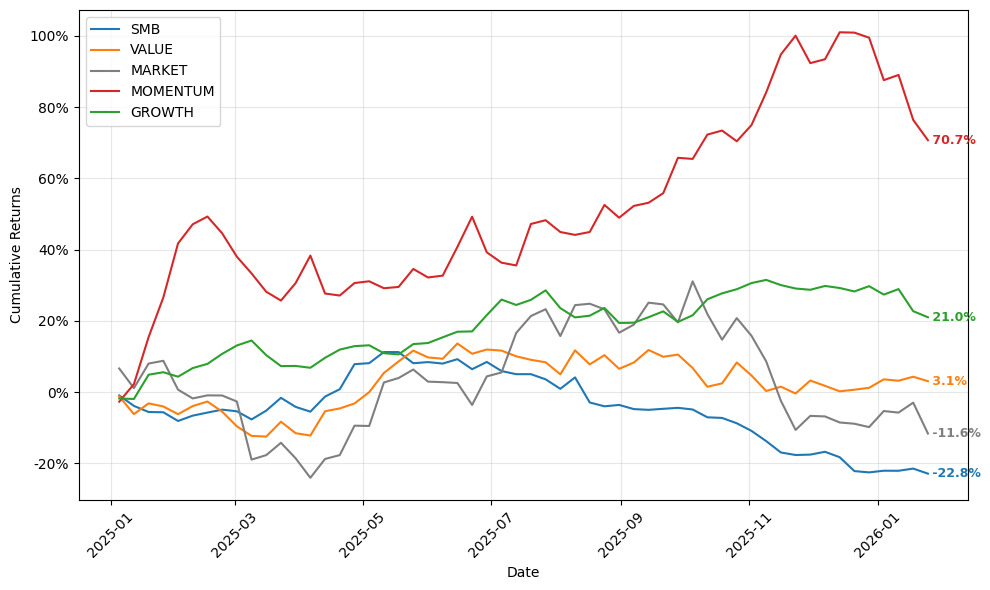

In [30]:
smb_factor_returns_df = pd.DataFrame(list(smb.factor_returns.items()), columns=['date', 'value'])
smb_factor_returns_df = smb_factor_returns_df.rename(columns={'value':'smb'})
value_factor_returns_df = pd.DataFrame(list(value.factor_returns.items()), columns=['date', 'value'])
value_factor_returns_df = value_factor_returns_df.rename(columns={'value':'value'})
market_factor_returns_df = pd.DataFrame(list(market.factor_returns.items()), columns=['date', 'value'])
market_factor_returns_df = market_factor_returns_df.rename(columns={'value':'market'})
momentum_v2_factor_returns_df = pd.DataFrame(list(momentum_v2.factor_returns.items()), columns=['date', 'value'])
momentum_v2_factor_returns_df = momentum_v2_factor_returns_df.rename(columns={'value':'momentum_v2'})
growth_factor_returns_df = pd.DataFrame(list(growth.factor_returns.items()), columns=['date', 'value'])
growth_factor_returns_df = growth_factor_returns_df.rename(columns={'value':'growth'})  

all_returns_df = smb_factor_returns_df.merge(value_factor_returns_df, left_on='date', right_on='date', how='inner').merge(market_factor_returns_df, left_on='date', right_on='date', how='inner').merge(momentum_v2_factor_returns_df, left_on='date', right_on='date', how='inner').merge(growth_factor_returns_df, left_on='date', right_on='date', how='inner')
all_returns_df = all_returns_df[['date', 'smb', 'value', 'market', 'momentum_v2', 'growth']]
all_returns_df = all_returns_df.set_index('date')

all_returns_df = all_returns_df[all_returns_df.index >= '2025-01-01']

for col in all_returns_df.columns:
    # convert to cumulative compounded returns
    all_returns_df[col] = (1 + all_returns_df[col]).cumprod() - 1

fig, ax1 = plt.subplots(figsize=(10, 6))

colors = {'smb': 'tab:blue', 'value': 'tab:orange', 'market': 'tab:gray', 'momentum_v2': 'tab:red', 'growth': 'tab:green'}
labels = {'smb': 'SMB', 'value': 'VALUE', 'market': 'MARKET', 'momentum_v2': 'MOMENTUM', 'growth': 'GROWTH'}

for col in all_returns_df.columns:
    ax1.plot(all_returns_df.index, all_returns_df[col], 
             linewidth=1.5, color=colors[col], label=labels[col])
    
    # Add final value annotation
    final_value = all_returns_df[col].iloc[-1]
    final_date = all_returns_df.index[-1]
    ax1.text(final_date, final_value, f' {final_value:.1%}', 
             va='center', ha='left', color=colors[col], fontsize=9, fontweight='bold')

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))
plt.show()

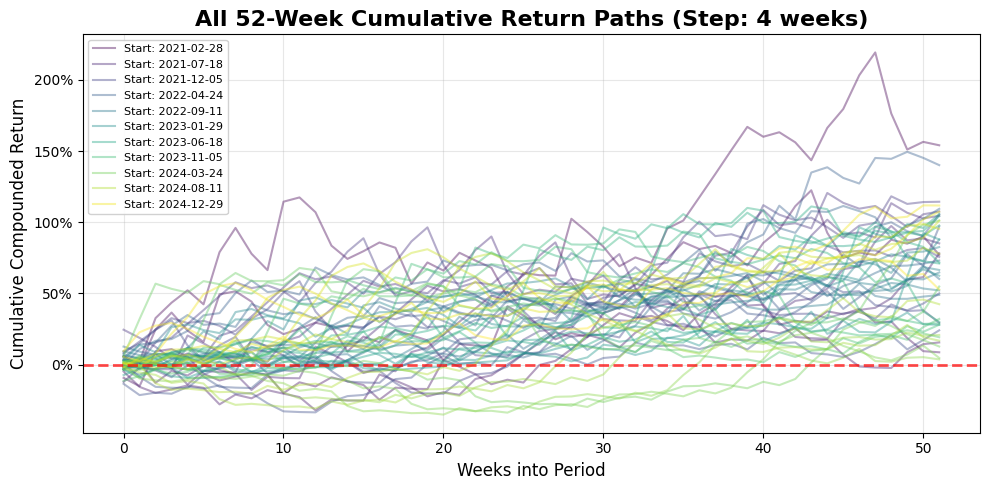

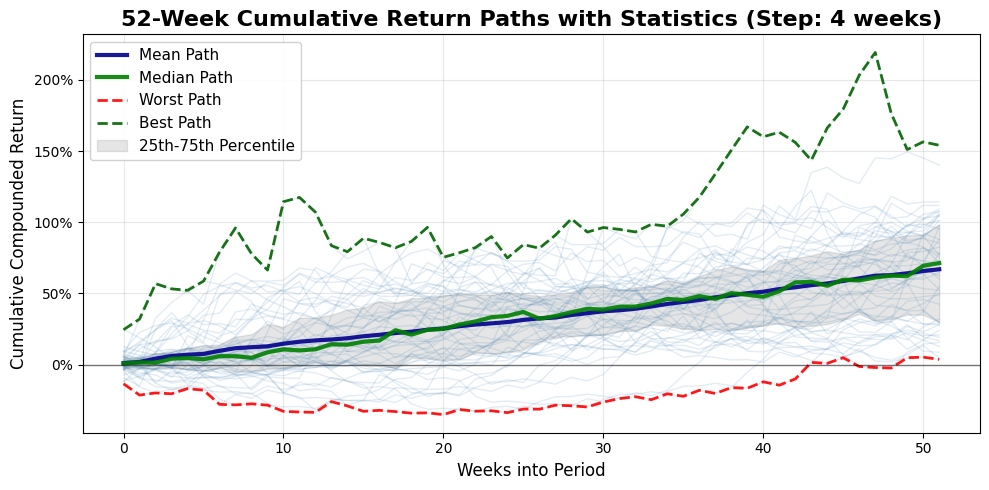


52-Week Path Statistics (Step size: 4 weeks):
Number of paths analyzed: 52
Final returns (week 52):
  Mean: 67.00%
  Median: 71.33%
  Best: 154.06%
  Worst: 3.71%
  25th percentile: 29.92%
  75th percentile: 98.61%


In [31]:

def plot_rolling_return_paths(returns_series, weeks=52, step_size=1, figsize=(10, 5)):
    """
    Plot rolling cumulative return paths
    
    Parameters:
    -----------
    returns_series : pd.Series
        Series of periodic returns with datetime index
    weeks : int
        Number of weeks in each rolling window (default: 52)
    step_size : int
        Step size between consecutive paths (default: 1)
        - step_size=1: every week (overlapping paths)
        - step_size=2: every 2 weeks
        - step_size=4: every 4 weeks
        - step_size=52: non-overlapping annual periods
    figsize : tuple
        Figure size for plots
    """
    
    # Sort the series
    returns_series = returns_series.sort_index()
    
    # Calculate number of paths based on step_size
    num_paths = (len(returns_series) - weeks) // step_size + 1
    
    # First chart: Individual colored paths
    plt.figure(figsize=figsize)
    
    colors = plt.cm.viridis(np.linspace(0, 1, num_paths))
    
    # Plot each path with step_size
    for idx, i in enumerate(range(0, len(returns_series) - weeks + 1, step_size)):
        # Get the window
        window = returns_series.iloc[i:i+weeks]
        
        # Calculate cumulative compounded returns for this path
        cumulative = (1 + window).cumprod() - 1
        
        # Create x-axis as weeks (0 to weeks-1)
        weeks_axis = np.arange(len(cumulative))
        
        # Plot this path
        label_freq = max(1, num_paths // 10)  # Show ~10 labels max
        plt.plot(weeks_axis, cumulative.values, alpha=0.4, linewidth=1.5, 
                 color=colors[idx], 
                 label=f"Start: {window.index[0].strftime('%Y-%m-%d')}" if idx % label_freq == 0 else "")
    
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.title(f'All {weeks}-Week Cumulative Return Paths (Step: {step_size} week{"s" if step_size > 1 else ""})', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Weeks into Period', fontsize=12)
    plt.ylabel('Cumulative Compounded Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format y-axis as percentage
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Add legend for some paths
    plt.legend(loc='upper left', fontsize=8, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    # Second chart: Paths with summary statistics
    plt.figure(figsize=figsize)
    
    all_paths = []
    for i in range(0, len(returns_series) - weeks + 1, step_size):
        window = returns_series.iloc[i:i+weeks]
        cumulative = (1 + window).cumprod() - 1
        all_paths.append(cumulative.values)
        
        # Plot individual paths
        weeks_axis = np.arange(len(cumulative))
        plt.plot(weeks_axis, cumulative.values, alpha=0.15, linewidth=1, color='steelblue')
    
    # Calculate and plot mean, median, min, max paths
    all_paths_array = np.array(all_paths)
    mean_path = np.mean(all_paths_array, axis=0)
    median_path = np.median(all_paths_array, axis=0)
    min_path = np.min(all_paths_array, axis=0)
    max_path = np.max(all_paths_array, axis=0)
    percentile_25 = np.percentile(all_paths_array, 25, axis=0)
    percentile_75 = np.percentile(all_paths_array, 75, axis=0)
    
    weeks_axis = np.arange(weeks)
    plt.plot(weeks_axis, mean_path, linewidth=3, color='darkblue', label='Mean Path', alpha=0.9)
    plt.plot(weeks_axis, median_path, linewidth=3, color='green', label='Median Path', alpha=0.9)
    plt.plot(weeks_axis, min_path, linewidth=2, color='red', label='Worst Path', linestyle='--', alpha=0.9)
    plt.plot(weeks_axis, max_path, linewidth=2, color='darkgreen', label='Best Path', linestyle='--', alpha=0.9)
    plt.fill_between(weeks_axis, percentile_25, percentile_75, alpha=0.2, color='gray', label='25th-75th Percentile')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.title(f'{weeks}-Week Cumulative Return Paths with Statistics (Step: {step_size} week{"s" if step_size > 1 else ""})', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Weeks into Period', fontsize=12)
    plt.ylabel('Cumulative Compounded Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{weeks}-Week Path Statistics (Step size: {step_size} week{'s' if step_size > 1 else ''}):")
    print(f"Number of paths analyzed: {len(all_paths)}")
    print(f"Final returns (week {weeks}):")
    print(f"  Mean: {mean_path[-1]:.2%}")
    print(f"  Median: {median_path[-1]:.2%}")
    print(f"  Best: {max_path[-1]:.2%}")
    print(f"  Worst: {min_path[-1]:.2%}")
    print(f"  25th percentile: {percentile_25[-1]:.2%}")
    print(f"  75th percentile: {percentile_75[-1]:.2%}")

# Usage examples:
returns_series = pd.Series(momentum_v2.factor_returns)

plot_rolling_return_paths(returns_series, weeks=52, step_size=4)



Sentiment Based Index Rebal Factor Model

In [32]:
# 1. Get the raw data (universe of assets)
# 2. Calculate weekly sentiment scores for each asset
# 3. Define the re-weighting methods
# 4. Calculate the sentiment adjusted returns for each asset
# 5. Calculate the schedueled factor returns
# 6. Run the backtest to see how it performs


# Sentiment Data
# Prediction Markets - Overall Macro Score Only
# Twitter - Ticker Specific Sentiment Scoring

In [33]:
coin_tickers = sorted({f"{asset.upper()}.X" for asset in df.reset_index()['asset'].unique()})

In [34]:
# Combine all monthly metrics DataFrames into a single DataFrame and export as CSV

combined_monthly_metrics = pd.concat([
    monthly_metrics_df_value.assign(factor='value'),
    monthly_metrics_df_smb.assign(factor='smb'),
    monthly_metrics_df_market.assign(factor='market'),
    monthly_metrics_df_growth.assign(factor='growth'),
    monthly_metrics_df_momentum_v2.assign(factor='momentum_v2'),
], ignore_index=True)

# combined_monthly_metrics.to_csv('combined_monthly_metrics.csv', index=False)

In [35]:
# years = [2021, 2022, 2023, 2024, 2025, 2026]

# for y in years:
#     # Get factor model monthly returns
#     factor_returns = {
#         name: monthly_returns(model, year=y, months=None) 
#         for name, model in models.items()
#     }
    
#     # Calculate monthly returns for risk-free rate
#     rf_filtered = rf_df[rf_df.index.year == y].copy()
#     if not rf_filtered.empty:
#         # Compound weekly risk-free rates within each month to get monthly returns
#         rf_monthly = rf_filtered['rf_weekly'].groupby(pd.Grouper(freq="M")).apply(
#             lambda x: (1 + x).prod() - 1
#         )
#         rf_monthly.index = rf_monthly.index.to_period("M").astype(str)
#         factor_returns['risk_free_rate'] = rf_monthly
    
#     monthly_breakdown_y = pd.concat(factor_returns, axis=1).sort_index()
#     monthly_breakdown_y.to_csv(f"monthly_returns_breakdown_{y}.csv")


In [36]:
test_data = get_coin_price_series('bitcoin', '2021-01-01', '2025-01-01')
print("Columns:", test_data.columns.tolist())
print("\nFirst few rows:")
print(test_data.head())
print("\nDataFrame shape:", test_data.shape)
print("\nDataFrame info:")
print(test_data.info())

Columns: ['TRADE_DATE', 'PRICE', 'DAILY_RETURN']

First few rows:
   TRADE_DATE         PRICE  DAILY_RETURN
0  2021-01-01  29022.418395           NaN
1  2021-01-02  29352.126792      0.011360
2  2021-01-03  32163.824935      0.095792
3  2021-01-04  33008.226203      0.026253
4  2021-01-05  31515.575967     -0.045221

DataFrame shape: (1462, 3)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TRADE_DATE    1462 non-null   object 
 1   PRICE         1462 non-null   float64
 2   DAILY_RETURN  1461 non-null   float64
dtypes: float64(2), object(1)
memory usage: 34.4+ KB
None


In [37]:
# Portfolio Beta Calculation Example

# Define symbol to CoinGecko ID mapping
SYMBOL_TO_COINGECKO = {
    'BTC': 'bitcoin',
    'ETH': 'ethereum',
    'SOL': 'solana',
    'AVAX': 'avalanche-2',
    'MATIC': 'matic-network',
    'ADA': 'cardano',
    'DOT': 'polkadot',
    'LINK': 'chainlink',
    'UNI': 'uniswap',
    'ATOM': 'cosmos'
}

# Define your portfolio with coin amounts (not percentages)
# Example: You own 0.5 BTC, 10 ETH, 100 SOL, etc.
portfolio = {
    'BTC': 0.5,    # 0.5 Bitcoin
    'ETH': 10,     # 10 Ethereum
    'SOL': 100,    # 100 Solana
    # Add more assets as needed
    # 'AVAX': 50,
    # 'MATIC': 1000,
}

# Define all factor strategies (assuming these are already created)
factors = {
    'value': value,
    'momentum': momentum_v2,
    'growth': growth,
    'market': market,
    'smb': smb
}

# Calculate portfolio beta to each factor
portfolio_beta_results = []

print("Calculating portfolio betas...")
print(f"Portfolio: {portfolio}\n")

for factor_name, factor_model in factors.items():
    try:
        beta = factor_model.get_portfolio_beta(
            portfolio=portfolio,
            symbol_to_coingecko=SYMBOL_TO_COINGECKO,
            min_observations=52,
            asset_type="crypto"
        )
        portfolio_beta_results.append({
            'Factor': factor_name,
            'Portfolio_Beta': beta
        })
        print(f"✅ {factor_name}: {beta:.4f}")
    except Exception as e:
        print(f"❌ Error calculating {factor_name}: {e}")
        portfolio_beta_results.append({
            'Factor': factor_name,
            'Portfolio_Beta': np.nan
        })

# Create DataFrame with results
portfolio_beta_df = pd.DataFrame(portfolio_beta_results)

# Display results
print("\n" + "="*50)
print("Portfolio Factor Betas Summary:")
print("="*50)
print(portfolio_beta_df.to_string(index=False))

# Interpretation
print("\n" + "="*50)
print("Interpretation:")
print("="*50)
print("Beta > 1.0: Portfolio moves more than the factor")
print("Beta = 1.0: Portfolio moves in line with the factor")
print("Beta < 1.0: Portfolio moves less than the factor")
print("Beta < 0: Portfolio moves opposite to the factor")

# Show the DataFrame
portfolio_beta_df

Calculating portfolio betas...
Portfolio: {'BTC': 0.5, 'ETH': 10, 'SOL': 100}

Error getting price for bitcoin: 'price'
Error getting price for ethereum: 'price'
Error getting price for solana: 'price'
Error: Could not calculate portfolio value
✅ value: nan
Error getting price for bitcoin: 'price'
Error getting price for ethereum: 'price'
Error getting price for solana: 'price'
Error: Could not calculate portfolio value
✅ momentum: nan
Error getting price for bitcoin: 'price'
Error getting price for ethereum: 'price'
Error getting price for solana: 'price'
Error: Could not calculate portfolio value
✅ growth: nan
Error getting price for bitcoin: 'price'
Error getting price for ethereum: 'price'
Error getting price for solana: 'price'
Error: Could not calculate portfolio value
✅ market: nan
Error getting price for bitcoin: 'price'
Error getting price for ethereum: 'price'
Error getting price for solana: 'price'
Error: Could not calculate portfolio value
✅ smb: nan

Portfolio Factor Betas

,Factor,Portfolio_Beta
0,value,NaN
1,momentum,NaN
2,growth,NaN
3,market,NaN
4,smb,NaN


In [38]:
# Testing Beta Calculation to Assets

# Define assets and their CoinGecko IDs
assets = {
    'BTC': 'bitcoin',
    'ETH': 'ethereum', 
    'SOL': 'solana'
}

# Define all factor strategies
factors = {
    'value': value,
    'momentum': momentum_v2,
    'growth': growth,
    'market': market, # raw beta
    'smb': smb
}

# Calculate betas for all combinations
beta_results = []

for asset_symbol, asset_id in assets.items():
    for factor_name, factor_model in factors.items():
        try:
            beta = factor_model.get_asset_beta(asset_id)
            beta_results.append({
                'Asset': asset_symbol,
                'Factor': factor_name,
                'Beta': beta
            })
        except Exception as e:
            print(f"Error calculating {asset_symbol} beta to {factor_name}: {e}")
            beta_results.append({
                'Asset': asset_symbol,
                'Factor': factor_name,
                'Beta': np.nan
            })

# Create DataFrame
beta_df = pd.DataFrame(beta_results)

# Pivot to show assets as rows and factors as columns
beta_pivot = beta_df.pivot(index='Asset', columns='Factor', values='Beta')

# Display results
print("Asset Factor Betas:")
print(beta_pivot)
print("\nDetailed view:")
print(beta_df)

# The beta_pivot DataFrame is ready to use
beta_pivot

Asset Factor Betas:
Factor    growth    market  momentum       smb     value
Asset                                                   
BTC     0.015145  0.102009  0.030029  0.094150  0.045957
ETH    -0.004861  0.132132  0.052668  0.119668  0.128304
SOL     0.129802  0.177980  0.000389  0.138319  0.173187

Detailed view:
   Asset    Factor      Beta
0    BTC     value  0.045957
1    BTC  momentum  0.030029
2    BTC    growth  0.015145
3    BTC    market  0.102009
4    BTC       smb  0.094150
5    ETH     value  0.128304
6    ETH  momentum  0.052668
7    ETH    growth -0.004861
8    ETH    market  0.132132
9    ETH       smb  0.119668
10   SOL     value  0.173187
11   SOL  momentum  0.000389
12   SOL    growth  0.129802
13   SOL    market  0.177980
14   SOL       smb  0.138319


Factor,growth,market,momentum,smb,value
Asset,,,,,
BTC,0.015145,0.102009,0.030029,0.094150,0.045957
ETH,-0.004861,0.132132,0.052668,0.119668,0.128304
SOL,0.129802,0.177980,0.000389,0.138319,0.173187


In [39]:
beta_pivot

Factor,growth,market,momentum,smb,value
Asset,,,,,
BTC,0.015145,0.102009,0.030029,0.094150,0.045957
ETH,-0.004861,0.132132,0.052668,0.119668,0.128304
SOL,0.129802,0.177980,0.000389,0.138319,0.173187
